# **PFM2 – Modelado y Aplicación Práctica.**

### Punto de partida
Este notebook continúa directamente el trabajo realizado en las Fases 1–6, utilizando como insumo el dataset validado `data/processed/subset_modelado.parquet`.  
Dicho dataset incluye:  
- La demanda original y ajustada.  
- La etiqueta `is_outlier` (procedente de DBSCAN).  
- Las nuevas columnas de trazabilidad anual (`tipo_outlier_year` y `decision_outlier_year`) generadas en la Fase 6.  

Este punto de partida garantiza que el modelado se apoya sobre datos consistentes, libres de anomalías espurias y con información de contexto suficiente para interpretar señales de negocio.

### Objetivo
Entrenar y evaluar modelos de predicción de demanda robustos, comparando diferentes enfoques (modelos estadísticos, machine learning y enfoques híbridos) y evaluando su capacidad para:  
- Integrar señales clave como top ventas y eventos de calendario.  
- Capturar tendencias, estacionalidades y picos de forma coherente.  
- Servir como base para la construcción de una aplicación interactiva en **Streamlit**, que permita al usuario explorar, simular y consumir las previsiones en un entorno operativo.  

### Referencia metodológica
Para una descripción detallada del tratamiento de outliers y validaciones aplicadas, ver `reports/outliers/outliers_resumen.csv` y el notebook de Fase 6.

---

### **Índice de Contenidos**

#### Fase 7: Validación y preparación del dataset para el modelado.
- 7.1. Validación inicial y del dataset.
- 7.2. Preparación de los datos para el modelado.
- 7.3. Target y features disponibles.


#### Fase 8: Modelado de la demanda. 
- 8.1. Preparación del dataset para entrenamiento. 
- 8.2. Baselines.
  - 8.2.1. Enfoque por clúster.
  - 8.2.2. Seasonal Naive.
  - 8.2.3. Holt-Winters (ETS).
  - 8.2.4. Comparación y conclusiones. 
- 2.3. Comparativa entre años: ¿se ha aplicado bien la estacionalidad?


#### Fase 3: Construcción del subset representativo.
- 3.1. Unificación de demandas (2022–2024).
- 3.2. Cruce con catálogo y asociación de categorías.
- 3.3. Filtrado de casos problemáticos.
- 3.4. Reducción de dimensionalidad (PCA sobre categorías).
- 3.5. Clustering de productos.
- 3.6. Generación del subset representativo.

#### Fase 4: Impacto del precio sobre la demanda.
- 4.1. Objetivo, datos de partida y mapeo de columnas y diseños del efecto precio (ventanas + elasticidades).
- 4.2. Preflight de ventanas — `ventanas_precio.py`
- 4.3. Aplicación del efecto — `aplicar_efecto_precio.py`
- 4.4. Validación rápida (sanity).
- 4.5. Validación adicional: alineamiento con calendario real.

#### Fase 5: Aplicación de factores externos y simulación de escenarios.
- 5.1. Introducción y objetivos.
- 5.2. Definición de factores externos.
- 5.3. Diseño del modelo de aplicación.
- 5.4. Implementación en código.
- 5.5. Validación de coherencia y robustez.
  - 5.5.1. Validación de coherencia del precio.
  - 5.5.2. Validación adicional (alineamiento ventanas).
  - 5.5.3. Comparativa de demanda.
  - 5.5.4. Validación de trazabilidad.
- 5.6. Conclusiones de la fase 5.

#### Fase 6: Análisis y tratamiento de outliers.
- 6.1. Validación complementaria: búsqueda de nuevos candidatos.
- 6.2. Análisis de outliers detectados por DBSCAN.
- 6.3. Resultados consolidados y decisiones finales.
- 6.4. Implicaciones para el modelado.
  - 6.4.1. Integración en el subset final.
  - 6.4.2. Visualización del impacto de outliers.


-----

⚠️ **Nota metodológica sobre los datos históricos utilizados.**

Los datos históricos correspondientes a los ejercicios 2022–2024 no proceden de registros reales de ventas, sino que fueron **generados a partir de la previsión de demanda 2025**. 
Para construir estos históricos se aplicaron de manera controlada diversos componentes que reflejan el comportamiento esperado en un contexto de comercio electrónico:

- **Patrón estacional**: incorporación de estacionalidad diaria y anual (ciclos de ingresos mensuales, rebajas, campañas como Black Friday, Prime Day, etc.).

- **Impacto del precio**: simulación del efecto del precio sobre la demanda, con distinta sensibilidad por clúster de producto.

- **Factores externos**: inclusión de variables de calendario y eventos promocionales como dummies exógenas.

- **Ruido controlado y aleatorio**: añadido de perturbaciones aleatorias con distribución normal, calibradas para introducir variabilidad sin distorsionar las tendencias de fondo.

> Este enfoque buscó **evitar la circularidad** inherente a la construcción de históricos a partir de una previsión futura, de manera que los modelos no aprendan relaciones deterministas y conserven capacidad de generalización.

🛑 **Limitaciones**

No obstante, este planteamiento presenta ciertas limitaciones que deben ser tenidas en cuenta en la interpretación de los resultados:

- Los datos de 2022–2024 heredan en gran medida las tendencias y estacionalidades de la previsión 2025, lo que puede reducir la 
  diversidad de patrones respecto a históricos reales.

- El ruido introducido, aunque aleatorio, no refleja en su totalidad la complejidad de desviaciones reales  
  (errores humanos, incidencias logísticas, cambios imprevistos de mercado).

- La validación mediante backtesting sobre 2024 se realiza frente a un histórico simulado a partir de 2025, lo que podría generar resultados 
  algo más optimistas que en un entorno con datos 100% reales.

🔍 **Enfoque adoptado**

A pesar de estas limitaciones, el enfoque es **válido y adecuado** para los objetivos del proyecto porque:

- Permite **evaluar de manera realista la metodología de predicción y el pipeline completo**(desde la generación de features hasta la selección de modelos).

- Introduce suficiente variabilidad y ruido para que los algoritmos deban **aprender patrones** y no simplemente replicar la previsión original.

- Facilita la comparación objetiva entre diferentes familias de modelos y la selección por clúster en base a métricas robustas (sMAPE, WAPE, MAE ponderado).

> En conclusión, los históricos generados proporcionan un marco de prueba **coherente y consistente** para validar la lógica del sistema de predicción y simulación de stock, 
entendiendo que los resultados no equivalen a un backtesting sobre datos 100% reales, sino a un escenario controlado que reproduce condiciones verosímiles.

📌 **Nota metodológica final sobre outliers y clusters**

En la Fase 2, a partir del clustering con DBSCAN, un conjunto reducido de productos quedó marcado como outliers. En lugar de eliminarlos del subset (como se hizo en clase), se decidió mantenerlos en el dataset, ya que el análisis posterior mostró que estos productos coincidían con dos situaciones:

- **Top ventas** → productos de alta rotación cuya exclusión hubiera distorsionado la demanda real.
- **Picos aislados coherentes** → ventas puntuales pero justificadas por campañas, estacionalidad o ventanas de grandes ventas.

Durante la Fase 6, para garantizar que todos los productos participaran en el modelado por clúster, se creó la columna __cluster__.

- En los productos no outliers (is_outlier = 0), cluster y __cluster__ son idénticos.
- En los productos outliers (is_outlier = 1), se aplicó un **criterio de fallback determinista**, asignándolos al clúster mayoritario (clúster 1).

**Limitaciones**

- Este enfoque diluye en cierta medida la especificidad de los outliers.
- Sin embargo, dado que en este caso **todos los outliers estaban justificados** (bien por ser top ventas, bien por picos coherentes con la época), su integración en el clúster mayoritario no compromete la validez del modelo.

**Enfoque adoptado**

- Se opta por mantener la asignación al clúster mayoritario para no dejar productos fuera del pipeline.
- Se documenta esta decisión como un compromiso entre simplicidad, cobertura y coherencia de negocio.
- Como línea futura, se podría explorar una reasignación basada en distancias a centroides u otras métricas, pero no se considera necesaria en esta fase.


**Posible línea futura: clustering específico de outliers**

En el presente proyecto los productos identificados como outliers fueron integrados en el clúster mayoritario con el objetivo de garantizar su cobertura en 
el modelado y evitar su eliminación, dado que en su mayoría correspondían a top ventas o a picos de demanda coherentes con la estacionalidad.

Como línea de trabajo futura, se podría plantear un clustering específico sobre el conjunto de outliers. Esta estrategia permitiría identificar subgrupos internos 
(por ejemplo, distinguir entre productos con alta rotación recurrente frente a productos con picos estacionales aislados) y, en consecuencia, aplicar modelos diferenciados más ajustados a cada comportamiento.

No obstante, dado que el volumen de productos outliers es reducido respecto al total (alrededor de un 5–6 %) y que los modelos con variables exógenas ya permiten explicar 
sus patrones de manera satisfactoria, se considera que esta extensión no es necesaria en la versión actual del modelo y se pospone como línea futura de refinamiento.

## FASE 7: **Validación y preparación del dataset para el modelado**.

En esta fase se lleva a cabo el último bloque de **preparación de datos** antes del entrenamiento de los modelos.  
El objetivo es garantizar que el dataset final cumple con todos los requisitos de **integridad, consistencia y trazabilidad**, de modo que pueda ser utilizado como entrada estable y homogénea en la fase de modelado.

**Objetivos principales.**
- Validar el dataset base (`subset_modelado.parquet`) para confirmar que no existen problemas estructurales (nulos, negativos, duplicados, incoherencias de clústeres u outliers).  
- Normalizar y depurar las columnas, renombrando y eliminando redundancias.  
- Definir explícitamente la variable objetivo (*target*) y las variables explicativas (*features*) disponibles para los modelos.  
- Generar un dataset final consolidado (`dataset_modelado_ready.parquet`) que actúe como **input único y reproducible** para todos los experimentos de la fase de modelado.


> 📌 Con esta fase se cierra todo el bloque de preparación, asegurando que los modelos de la Fase 8 se entrenarán sobre datos limpios, validados y coherentes.

### **7.1. Validación inicial del dataset.**


El primer paso antes de comenzar con el modelado consiste en realizar una **validación exhaustiva del dataset de partida**.  
El objetivo de este bloque es garantizar que los datos sobre los que se entrenarán los modelos son **consistentes, completos y utilizables**, evitando que errores estructurales condicionen los resultados posteriores.

🎯 **Objetivo**
- Comprobar que la **variable objetivo** (`demand_final_noised`) no presenta valores nulos ni negativos.
- Verificar que las **fechas** cubren el rango esperado (2022–2024) y que no existen duplicados en la combinación (`product_id`, `date`).
- Identificar posibles problemas de cobertura temporal (fechas faltantes, series constantes, productos incompletos).
- Validar que todos los **productos tienen un clúster asignado** y que la información de outliers está correctamente registrada.
- Revisar de forma preliminar las **variables de precio y factores externos**.

❓ **Por qué se realiza**
Una validación previa es esencial porque:
- Asegura que los **modelos trabajen con datos coherentes** y sin inconsistencias.
- Evita que los resultados del backtesting estén sesgados por errores de entrada.
- Permite identificar productos o periodos problemáticos antes de invertir tiempo en el entrenamiento.

🛠️ **Cómo se lleva a cabo**
La validación se efectúa mediante un **script específico** (`validacion_dataset_modelado.py`) que genera un reporte con:
- Información general del dataset.
- Estado de la variable objetivo.
- Cobertura temporal por producto.
- Comprobaciones sobre clústeres y outliers.
- Un **resumen tipo semáforo** (OK/NO-OK) de las validaciones críticas.

> De esta manera, cualquier problema estructural queda documentado y puede ser corregido antes de pasar a la fase de preparación de datos.


⚙️ **Script: `validacion_dataset_modelado.py`**

🎯 **Objetivo.**  
Automatizar la validación del dataset de modelado, comprobando la integridad de la variable objetivo, la cobertura temporal, los clústeres y la trazabilidad de los outliers. Este script actúa como herramienta de diagnóstico previa al modelado.

➡️ **Entradas.**
- `data/processed/subset_modelado.parquet` (dataset validado en Fases 1–6).

⬅️ **Salidas.**
- Reporte en consola con todos los resultados de validación.  
- (Opcional) Archivo TXT si se especifica `--report`.

🔁 **Flujo de trabajo.**
1. **Carga del dataset** (Parquet).  
2. **Chequeo de columnas y tipos** (`df.info()` capturado en buffer).  
3. **Validación de la variable objetivo**: nulos, negativos, estadísticos básicos.  
4. **Cobertura temporal**: fechas mínimas/máximas globales y por producto; detección de duplicados `product_id+date`; cálculo de completitud diaria.  
5. **Series constantes**: identifica productos con demanda sin variación.  
6. **Precio y factores**: detección de valores nulos/negativos en columnas relevantes (`precio_medio`, `price_factor_effective`).  
7. **Validación de clústeres**: confirmación de que todos los productos tienen clúster asignado; coherencia `cluster` vs `__cluster__` en productos no-outlier.  
8. **Outliers**: verificación de columnas relacionadas, recuento de productos marcados y número de clústeres asignados.  
9. **Resumen “semáforo”**: indicadores booleanos (`OK=True/False`) de las comprobaciones críticas.

🪛 **Parámetros modificables.**
- Rutas de entrada y salida (`--in`, `--report`).
- Nombre de la variable objetivo (`demand_final_noised` por defecto).

🧩 **Ejecución.**
- CLI:  
  ```bash
  python scripts/eda/validacion_dataset_modelado.py
  python scripts/eda/validacion_dataset_modelado.py --report reports/validacion_dataset.txt

- Notebook:

 `from scripts.eda.validacion_dataset_modelado import run_validation`
 
 `print(run_validation())`

📝 **Notas.**
- El script no modifica el dataset original.
- Si se encuentra algún problema crítico (ej. nulos en target, fechas fuera de rango), debe ser corregido antes de continuar con el modelado.

In [6]:
# =============================================================================
# Script: validación_dataset_modelado.py
# Validación inicial del dataset de modelado
# Objetivo: foto rápida y completa de calidad de datos y trazabilidad de clúster/outliers
# =============================================================================


from __future__ import annotations
from pathlib import Path
import argparse
import logging
import io
import pandas as pd
import numpy as np

# ---------- Helper: encontrar raíz del repo (carpeta que contenga data/processed) ----------
def find_repo_root(start: Path | None = None) -> Path:
    p = Path(start or Path.cwd()).resolve()
    for parent in (p, *p.parents):
        if (parent / "data" / "processed").exists():
            return parent
    return p  # fallback: cwd si no encuentra nada

# ---------- Rutas por defecto (funciona en script y en notebook) ----------
if "__file__" in globals():
    _start = Path(__file__).resolve().parent
    LOGGER_NAME = Path(__file__).stem
else:
    _start = Path.cwd()
    LOGGER_NAME = "notebook.validacion_dataset_modelado"

ROOT_DIR = find_repo_root(_start)
PROCESSED_DIR = ROOT_DIR / "data" / "processed"

# ---------- Logging ----------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
)
log = logging.getLogger(LOGGER_NAME)


# ---------- Núcleo de validación ----------
def validate_dataset(df: pd.DataFrame, target: str = "demand_final_noised") -> str:
    """Devuelve un string con el reporte de validación."""
    lines: list[str] = []

    # 1) Columnas / tipos
    lines.append("=== ENCABEZADOS ===")
    lines.append(str(list(df.columns)))

    lines.append("\n=== INFO ===")
    buf = io.StringIO()                       # <- buffer válido para df.info()
    df.info(buf=buf, show_counts=True)
    lines.extend(buf.getvalue().splitlines())

    # 2) Target
    assert target in df.columns, f"No existe la columna objetivo '{target}'"
    tgt = df[target]
    lines.append(f"\n=== TARGET ({target}) ===")
    lines.append(f"Nulos: {int(tgt.isna().sum())}")
    lines.append(f"Negativos: {int((tgt < 0).sum())}")
    lines.append(str(tgt.describe()))

    # 3) Fechas y cobertura
    assert "date" in df.columns, "Falta columna 'date'"
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    lines.append("\n=== COBERTURA GLOBAL DE FECHAS ===")
    lines.append(f"Min: {df['date'].min()}  |  Max: {df['date'].max()}")

    # Duplicados product_id+date
    dups = int(df.duplicated(["product_id", "date"]).sum())
    lines.append(f"\nDuplicados (product_id, date): {dups}")

    # Continuidad diaria por producto
    span = df.groupby("product_id")["date"].agg(["min", "max", "count"])
    span["dias_esperados"] = (span["max"] - span["min"]).dt.days + 1
    span["completitud_%"] = (span["count"] / span["dias_esperados"] * 100).round(2)
    faltantes = int((span["completitud_%"] < 100).sum())
    lines.append(f"Productos con fechas faltantes: {faltantes}")
    lines.append(f"Completitud media %: {span['completitud_%'].mean().round(2)}")

    # Series constantes
    var0 = int((df.groupby("product_id")[target].nunique() == 1).sum())
    lines.append(f"Productos con demanda constante (único valor): {var0}")

    # 4) Precio (si existe)
    for col in ["precio_medio", "price_factor_effective"]:
        if col in df.columns:
            lines.append(f"\n=== CHEQUEO {col} ===")
            lines.append(
                f"Nulos: {int(df[col].isna().sum())} | Negativos: {int((df[col] < 0).sum())} "
                f"| Min: {df[col].min()} | Max: {df[col].max()}"
            )

    # 5) Clústeres
    cluster_col = "__cluster__" if "__cluster__" in df.columns else ("cluster" if "cluster" in df.columns else None)
    assert cluster_col is not None, "No hay columna de cluster ni __cluster__"
    lines.append(f"\n=== CLÚSTERES ({cluster_col}) ===")
    lines.append(f"Productos únicos: {df['product_id'].nunique()}")
    lines.append(f"Productos con cluster: {df.loc[df[cluster_col].notna(), 'product_id'].nunique()}")
    lines.append(f"Productos SIN cluster: {df.loc[df[cluster_col].isna(), 'product_id'].nunique()}")

    # Coherencia en NO-outliers
    if {"cluster", "__cluster__", "is_outlier"}.issubset(df.columns):
        no_out = df["is_outlier"].eq(0)
        iguales = (df.loc[no_out, "cluster"].fillna(-1).astype(int)
                   == df.loc[no_out, "__cluster__"].astype(int)).all()
        lines.append(f"Cluster y __cluster__ idénticos en NO-outliers: {bool(iguales)}")

    # 6) Outliers
    outlier_cols = [c for c in df.columns if "outlier" in c.lower()]
    lines.append("\n=== COLUMNAS OUTLIERS ===")
    lines.append(str(outlier_cols))
    if "is_outlier" in df.columns:
        n_out = int(df.query("is_outlier == 1")["product_id"].nunique())
        lines.append(f"Productos outlier: {n_out}")
        asign = df.loc[df["is_outlier"] == 1, ["product_id", cluster_col]].drop_duplicates()
        lines.append(f"Clusters distintos en outliers: {asign[cluster_col].nunique()}")

    # 7) Resumen semáforo
    checks = {
        "target_sin_nulos": int(tgt.isna().sum()) == 0,
        "target_sin_negativos": int((tgt < 0).sum()) == 0,
        "sin_duplicados_pid_fecha": dups == 0,
        "cluster_cubierto": df.loc[df[cluster_col].isna(), "product_id"].nunique() == 0,
    }
    lines.append("\n=== RESUMEN (OK=True) ===")
    for k, v in checks.items():
        lines.append(f"{k}: {bool(v)}")

    return "\n".join(lines)


# ---------- CLI (ignora flags extra de Jupyter) ----------
def _parse_args() -> argparse.Namespace:
    p = argparse.ArgumentParser(description="Validación inicial del dataset de modelado (no escribe por defecto).")
    p.add_argument("--in", dest="inp", type=str, default=str(PROCESSED_DIR / "subset_modelado.parquet"),
                   help="Ruta de entrada (PARQUET).")
    p.add_argument("--report", dest="report", type=str, default="",
                   help="Ruta TXT para volcar el reporte (opcional).")
    args, _ = p.parse_known_args()
    return args


# ---------- Atajo para usar desde notebook ----------
def run_validation(inp: str | Path = None, report: str | Path = None) -> str:
    inp_path = Path(inp) if inp else (PROCESSED_DIR / "subset_modelado.parquet")
    log.info("Leyendo: %s", inp_path)
    df = pd.read_parquet(inp_path)
    log.info("Validando…")
    rep = validate_dataset(df)
    if report:
        report = Path(report)
        report.parent.mkdir(parents=True, exist_ok=True)
        report.write_text(rep, encoding="utf-8")
        log.info("Reporte guardado en: %s", report)
    return rep


def main() -> None:
    args = _parse_args()
    txt = run_validation(args.inp, args.report)
    print(txt)


if __name__ == "__main__":
    main()


2025-09-08 11:29:18,994 | INFO | notebook.validacion_dataset_modelado | Leyendo: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\subset_modelado.parquet
2025-09-08 11:29:19,657 | INFO | notebook.validacion_dataset_modelado | Validando…


=== ENCABEZADOS ===
['precio_medio', 'product_id', 'demand_day', 'is_outlier', 'cluster', 'date', '__cluster__', '__product_id__', 'demand_multiplier', 'demand_day_priceadj', 'price_factor_effective', 'price_virtual', 'm_agosto_nonprice', 'm_competition', 'm_inflation', 'm_promo', 'm_seasonextra', 'm_segments', 'demand_final', 'factors_applied', 'demand_final_noised', 'demand_final_noiseds_adj', 'year', 'tipo_outlier_year', 'decision_outlier_year']

=== INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941216 entries, 0 to 3941215
Data columns (total 25 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   precio_medio              3941216 non-null  float64       
 1   product_id                3941216 non-null  string        
 2   demand_day                3941216 non-null  float64       
 3   is_outlier                3941216 non-null  int64         
 4   cluster                   37209

📊 **Resultados de la validación inicial del dataset**

La validación aplicada sobre `subset_modelado.parquet` confirma que el dataset de partida es **consistente y apto para el modelado**.  

**Principales resultados:**
- ✔️ **Estructura completa**: se detectaron 25 columnas, incluyendo demanda, producto, clústeres, precios y factores externos.  
- ✔️ **Variable objetivo (`demand_final_noised`)**: sin valores nulos ni negativos.  
- ✔️ **Integridad temporal**: fechas cubren el rango esperado (2022–2024), sin duplicados en la combinación (`product_id`, `date`).  
- ✔️ **Cobertura de clústeres**: todos los productos tienen un clúster asignado.  
- ✔️ **Factores de precio y externos**: columnas presentes y sin anomalías graves.  

**Implicaciones para el modelado:**
- El dataset puede utilizarse directamente en la preparación (fase 7.2) sin necesidad de limpieza adicional.  
- La ausencia de nulos/duplicados evita sesgos en el backtesting y facilita la comparabilidad de métricas.  
- La cobertura de clústeres garantiza que se pueda aplicar el enfoque de modelado **por clúster**, manteniendo consistencia metodológica.  

> En conclusión, el dataset validado ofrece una **base sólida y coherente** para iniciar la fase de modelado, reduciendo riesgos de errores estructurales.

Además de la validación principal, se cuenta con un **script específico** (`check_outliers_clusters.py`)para auditar la coherencia de los *outliers* respecto a los clústeres.

**Objetivo.**  
Comprobar que:
- Los productos no marcados como *outliers* mantienen coherencia entre `cluster` y `__cluster__`.
- Los productos marcados como *outliers* tienen un clúster asignado y se registra correctamente su distribución.

**Entradas.**
- `data/processed/subset_modelado.parquet`

**Salidas.**
- Reporte en consola con:
  - Distribución de clústeres.
  - Coherencia `cluster` vs `__cluster__` en productos no-outlier.
  - Resumen de productos outlier y clústeres asignados.

**Uso.**
- CLI:
  ```bash
  python scripts/eda/check_outliers_clusters.py
  python scripts/eda/check_outliers_clusters.py --report reports/outliers/summary_outliers_clusters.txt

**Notas.**

- Este script se considera una herramienta auxiliar para auditorías puntuales.
- Su ejecución no es obligatoria en el pipeline, ya que la validación principal (validacion_dataset_modelado.py) garantiza la integridad global.
- Se recomienda utilizarlo si se desea revisar en detalle la trazabilidad de los outliers o documentar auditorías específicas.


📊 **Resultados de la comprobación auxiliar de outliers y clústeres**
Se ejecutó el script `check_outliers_clusters.py` para verificar la coherencia de los *outliers* en relación con los clústeres.  

**Principales hallazgos:**
- ✔️ **Distribución de clústeres**: se identificaron 4 valores (0–3), con asignación equilibrada y sin anomalías.
- ✔️ **No-outliers**: las columnas `cluster` y `__cluster__` son idénticas para todos los productos → confirmada la coherencia.
- ✔️ **Outliers**: 201 productos fueron marcados como outliers, y todos ellos fueron asignados de forma determinista al clúster mayoritario (`__cluster__ = 1`).

**Implicaciones:**
- La asignación determinista a clúster 1 asegura que ningún producto queda fuera del pipeline de modelado.
- La validación confirma que no existen inconsistencias entre `cluster` y `__cluster__` en los productos no-outlier.
- La estrategia adoptada (incluir outliers como parte del clúster mayoritario) se mantiene válida y no compromete la coherencia metodológica.

### **7.2. Preparación de los datos para el modelado.**



Tras validar la integridad del dataset en el apartado 7.1, el siguiente paso consiste en **normalizar y depurar la estructura de datos** para que pueda ser utilizada directamente en el entrenamiento de los modelos.

🎯 **Objetivo**.
- Unificar nombres de columnas clave.
- Eliminar duplicados y redundancias.
- Definir explícitamente el target y las features.
- Generar un dataset limpio y homogéneo que sirva como input estándar para todos los modelos.

🔁 **Pasos realizados**.
1. **Renombrado de columnas:**
   - `__cluster__` → `cluster_id`  
   - `demand_final_noised` → `sales_quantity`  

2. **Eliminación de duplicados:**
   - Se descartan `cluster` y `__product_id__`, ya que eran copias redundantes de `__cluster__` y `product_id`.

3. **Selección de variables explicativas (features):**
   - Precio: `precio_medio`, `price_virtual`, `price_factor_effective`, `demand_day_priceadj`.  
   - Factores externos: `m_agosto_nonprice`, `m_competition`, `m_inflation`, `m_promo`, entre otros.  
   - Outliers y trazabilidad: `is_outlier`, `tipo_outlier_year`, `decision_outlier_year`.  
   - Identificadores y fecha: `product_id`, `cluster_id`, `date`.

4. **Control de consistencia:**
   - Verificación de ausencia de duplicados en (`product_id`, `date`).  
   - Confirmación de que no existen valores nulos en la variable objetivo (`sales_quantity`).

5. **Exportación:**
   - Se genera el dataset final `data/processed/dataset_modelado_ready.parquet`, que será utilizado de manera uniforme en todos los experimentos de modelado.

🧪 **Resultado**.
El dataset preparado garantiza una **base coherente, sin ambigüedades ni redundancias**, y con una estructura estable que facilita:
- La aplicación consistente de modelos estadísticos y de machine learning.  
- La reproducibilidad de los experimentos (todos los modelos parten de la misma entrada).  
- La trazabilidad de resultados (columnas de target y features claramente identificadas).


⚙️ **Script: `preparacion_dataset_modelado.py`**

🎯 **Objetivo.**  
Normalizar y depurar el dataset de partida para que quede listo para el modelado, eliminando redundancias y asegurando que la estructura sea homogénea y estable.

➡️ **Entradas.**
- `data/processed/subset_modelado.parquet`

⬅️ **Salidas.**
- `data/processed/dataset_modelado_ready.parquet` (dataset final listo para modelado).

🔁 **Flujo de trabajo.**
1. **Renombrado de columnas clave**  
   - `__cluster__` → `cluster_id`  
   - `demand_final_noised` → `sales_quantity`  

2. **Eliminación de columnas redundantes**  
   - `cluster` (duplicado de `__cluster__`),  
   - `__product_id__` (duplicado de `product_id`),  
   - `demand_final_noiseds_adj` (columna auxiliar no utilizada).  

3. **Normalización de tipos**  
   - `date` → formato datetime.  
   - `product_id` → string.  
   - `cluster_id` → entero (`int` o `Int64` si hay nulos).  

4. **Control de duplicados y nulos**  
   - Eliminación de duplicados por (`product_id`, `date`).  
   - Filtrado de posibles nulos en `sales_quantity`.  

5. **Selección de variables finales**  
   - Identificadores y target: `product_id`, `date`, `cluster_id`, `sales_quantity`.  
   - Features de precio, factores externos y trazabilidad (`precio_medio`, `price_virtual`, `m_promo`, `is_outlier`, etc.).  
   - Ordenación por (`product_id`, `date`).  

6. **Exportación**  
   - Se guarda el dataset consolidado en `data/processed/dataset_modelado_ready.parquet`.  

📝 **Notas.**
- Este dataset es la **base de referencia para todos los modelos** de la Fase 7, evitando revalidaciones y asegurando consistencia.  
- La eliminación de redundancias y la normalización de tipos garantizan la trazabilidad y reproducibilidad de los resultados.  


In [10]:

# =============================================================================
# Script: preparacion_dataset_modelado.py
# =============================================================================

from __future__ import annotations
from pathlib import Path
import argparse
import logging
import pandas as pd

# ---------- Helper: localizar raíz del repo (busca data/processed hacia arriba)
def find_repo_root(start: Path | None = None) -> Path:
    p = Path(start or Path.cwd()).resolve()
    for parent in (p, *p.parents):
        if (parent / "data" / "processed").exists():
            return parent
    return p  # fallback

# ---------- Entorno (sirve para script y notebook)
if "__file__" in globals():
    _start = Path(__file__).resolve().parent
    LOGGER_NAME = Path(__file__).stem
else:
    _start = Path.cwd()
    LOGGER_NAME = "notebook.preparacion_dataset_modelado"

ROOT_DIR = find_repo_root(_start)
PROCESSED_DIR = ROOT_DIR / "data" / "processed"

# ---------- Logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
)
log = logging.getLogger(LOGGER_NAME)

# ---------- Config “suave”: columnas a eliminar/renombrar/usar si existen
RENAME_MAP = {
    "__cluster__": "cluster_id",
    "demand_final_noised": "sales_quantity",
}
DROP_CANDIDATES = [
    "cluster",               # duplicado: nos quedamos con __cluster__ -> cluster_id
    "__product_id__",        # duplicado de product_id
    "demand_final_noiseds_adj",  # columna auxiliar que no aporta
]
# Features recomendadas (se usará la intersección para evitar KeyError)
FEATURES_RECOMENDADAS = [
    # ids & fecha (estos los forzamos aparte)
    # target -> sales_quantity (tras renombrado)
    "precio_medio",
    "price_virtual",
    "price_factor_effective",
    "demand_day_priceadj",
    # factores externos
    "m_agosto_nonprice",
    "m_competition",
    "m_inflation",
    "m_promo",
    # trazabilidad/outliers (opcionales, según uso como exógenas)
    "is_outlier",
    "tipo_outlier_year",
    "decision_outlier_year",
]

# ---------- Núcleo ------------------------------------------------------------
def prepare_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Aplica la preparación para modelado y devuelve el DataFrame listo."""
    df = df.copy()

    # 1) Renombrados (solo si existen)
    cols_a_renombrar = {c: n for c, n in RENAME_MAP.items() if c in df.columns}
    df = df.rename(columns=cols_a_renombrar)

    # Validaciones mínimas
    required = {"product_id", "date", "cluster_id", "sales_quantity"}
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas requeridas tras renombrado: {missing}")

    # 2) Eliminar columnas redundantes si existen
    to_drop = [c for c in DROP_CANDIDATES if c in df.columns]
    if to_drop:
        log.info("Eliminando columnas redundantes: %s", to_drop)
        df = df.drop(columns=to_drop)

    # 3) Normalizar tipos
    df["date"] = pd.to_datetime(df["date"])
    df["product_id"] = df["product_id"].astype(str)
    # cluster_id como int (permitiendo nulos si los hubiera por seguridad)
    if df["cluster_id"].isna().any():
        df["cluster_id"] = df["cluster_id"].astype("Int64")
    else:
        df["cluster_id"] = df["cluster_id"].astype(int)

    # 4) Control de duplicados por (product_id, date)
    dups = df.duplicated(["product_id", "date"])
    n_dup = int(dups.sum())
    if n_dup > 0:
        log.warning("Se detectaron %s duplicados (product_id, date). Se conservará el primero.", n_dup)
        df = df.loc[~dups].copy()

    # 5) Verificación de nulos en target
    n_null_target = int(df["sales_quantity"].isna().sum())
    if n_null_target > 0:
        log.warning("Se encontraron %s nulos en sales_quantity. Filtrando filas nulas.", n_null_target)
        df = df.loc[df["sales_quantity"].notna()].copy()

    # 6) Selección de columnas finales (intersección segura)
    keep_base = ["product_id", "date", "cluster_id", "sales_quantity"]
    keep_feats = [c for c in FEATURES_RECOMENDADAS if c in df.columns]
    cols_finales = keep_base + keep_feats
    df = df[cols_finales].sort_values(["product_id", "date"]).reset_index(drop=True)

    return df

# ---------- CLI ---------------------------------------------------------------
def _parse_args() -> argparse.Namespace:
    p = argparse.ArgumentParser(description="Preparación del dataset para modelado.")
    p.add_argument("--in",  dest="inp",  type=str, default=str(PROCESSED_DIR / "subset_modelado.parquet"),
                   help="Ruta de entrada (PARQUET).")
    p.add_argument("--out", dest="outp", type=str, default=str(PROCESSED_DIR / "dataset_modelado_ready.parquet"),
                   help="Ruta de salida (PARQUET).")
    # Ignora flags de Jupyter si corre dentro de notebook
    args, _ = p.parse_known_args()
    return args

def run_prep(inp: str | Path = None, outp: str | Path = None) -> str:
    """Atajo para usar desde notebook o como función."""
    inp_path = Path(inp) if inp else (PROCESSED_DIR / "subset_modelado.parquet")
    out_path = Path(outp) if outp else (PROCESSED_DIR / "dataset_modelado_ready.parquet")

    log.info("Leyendo: %s", inp_path)
    df = pd.read_parquet(inp_path)

    log.info("Preparando dataset…")
    df_ready = prepare_dataset(df)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    df_ready.to_parquet(out_path, index=False)
    log.info("Guardado dataset listo para modelado en: %s", out_path)

    return str(out_path)

def main() -> None:
    args = _parse_args()
    run_prep(args.inp, args.outp)

if __name__ == "__main__":
    main()


2025-09-08 12:29:42,828 | INFO | notebook.preparacion_dataset_modelado | Leyendo: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\subset_modelado.parquet
2025-09-08 12:29:43,464 | INFO | notebook.preparacion_dataset_modelado | Preparando dataset…
2025-09-08 12:29:43,837 | INFO | notebook.preparacion_dataset_modelado | Eliminando columnas redundantes: ['cluster', '__product_id__', 'demand_final_noiseds_adj']
2025-09-08 12:29:46,970 | INFO | notebook.preparacion_dataset_modelado | Guardado dataset listo para modelado en: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\dataset_modelado_ready.parquet


✅ **Verificación post-transformación del dataset listo para modelado.**

Tras la preparación del dataset (`dataset_modelado_ready.parquet`), se realiza una verificación ligera para asegurar que la transformación **no ha introducido errores** y que la estructura final es apta para los modelos.

**Qué se comprueba:**
- **Cobertura temporal:** las fechas abarcan el rango esperado (2022-01-01 → 2024-12-31).
- **Target (`sales_quantity`):** sin valores **nulos** ni **negativos**.  
  > No se validan los **ceros** porque son coherentes con días sin ventas.
- **Identificador (`product_id`):** sin nulos, sin valores “0” ni cadenas vacías.
- **Duplicados:** no existen duplicados en la combinación (`product_id`, `date`).
- **Clúster (`cluster_id`):** sin valores nulos y con valores dentro del rango esperado.

**Por qué es necesaria esta verificación:**
- Cada transformación (renombrados, drops, normalización) puede introducir errores de forma accidental.
- Esta comprobación actúa como **“post-check”** del bloque 7.2 y da garantías de que el dataset preparado mantiene la **integridad y consistencia** exigidas por el pipeline de modelado.

> Esta verificación es **operativa** y se mantiene en el **notebook** (no forma parte del pipeline en scripts) para agilizar el trabajo exploratorio y la defensa del proyecto.

In [11]:
# =============================================================================
# Script: preparacion_dataset_modelado.py
# =============================================================================

import pandas as pd
from pathlib import Path

# === Config ===
PATH_READY = Path(r"C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\dataset_modelado_ready.parquet")
FECHA_MIN_ESPERADA = pd.Timestamp("2022-01-01")
FECHA_MAX_ESPERADA = pd.Timestamp("2024-12-31")

# === Carga ===
df = pd.read_parquet(PATH_READY)

# Asegurar tipos
df["date"] = pd.to_datetime(df["date"])
df["product_id"] = df["product_id"].astype(str)

print("=== Cobertura temporal ===")
print("Fecha mínima:", df["date"].min())
print("Fecha máxima:", df["date"].max())
cobertura_ok = (df["date"].min() <= FECHA_MIN_ESPERADA) and (df["date"].max() >= FECHA_MAX_ESPERADA)
print("Cobertura dentro del rango esperado:", cobertura_ok)

print("\n=== sales_quantity (target) ===")
print("Nulos:", int(df["sales_quantity"].isna().sum()))
print("Negativos:", int((df["sales_quantity"] < 0).sum()))
target_ok = (df["sales_quantity"].isna().sum() == 0) and ((df["sales_quantity"] < 0).sum() == 0)
print("Target OK (sin nulos ni negativos):", target_ok)

print("\n=== product_id ===")
print("Nulos:", int(df["product_id"].isna().sum()))
print("Valores '0':", int((df["product_id"] == "0").sum()))
print("Vacíos (''):", int((df["product_id"].str.len() == 0).sum()))
print("Únicos:", df["product_id"].nunique())
pid_ok = (df["product_id"].isna().sum() == 0) and ((df["product_id"] == "0").sum() == 0) and ((df["product_id"].str.len() == 0).sum() == 0)
print("product_id OK (no nulos/0/vacíos):", pid_ok)

print("\n=== Duplicados (product_id, date) ===")
dup_count = int(df.duplicated(["product_id", "date"]).sum())
print("Duplicados:", dup_count)
dups_ok = dup_count == 0
print("Sin duplicados pid+date:", dups_ok)

print("\n=== cluster_id ===")
print("Nulos:", int(df["cluster_id"].isna().sum()))
vals = sorted(pd.Series(df["cluster_id"].dropna().unique()).tolist())
print("Valores únicos:", vals)
cluster_ok = df["cluster_id"].isna().sum() == 0
print("cluster_id OK (sin nulos):", cluster_ok)

print("\n=== Resumen (OK=True) ===")
checks = {
    "cobertura_temporal_ok": cobertura_ok,
    "target_ok": target_ok,
    "product_id_ok": pid_ok,
    "sin_duplicados_pid_date": dups_ok,
    "cluster_ok": cluster_ok,
}
for k, v in checks.items():
    print(f"{k}: {bool(v)}")

=== Cobertura temporal ===
Fecha mínima: 2022-01-01 00:00:00
Fecha máxima: 2024-12-31 00:00:00
Cobertura dentro del rango esperado: True

=== sales_quantity (target) ===
Nulos: 0
Negativos: 0
Target OK (sin nulos ni negativos): True

=== product_id ===
Nulos: 0
Valores '0': 0
Vacíos (''): 0
Únicos: 3596
product_id OK (no nulos/0/vacíos): True

=== Duplicados (product_id, date) ===
Duplicados: 0
Sin duplicados pid+date: True

=== cluster_id ===
Nulos: 0
Valores únicos: [0, 1, 2, 3]
cluster_id OK (sin nulos): True

=== Resumen (OK=True) ===
cobertura_temporal_ok: True
target_ok: True
product_id_ok: True
sin_duplicados_pid_date: True
cluster_ok: True


📊 **Resultados de la verificación post-transformación**.

La verificación realizada sobre el dataset `dataset_modelado_ready.parquet` confirma que la transformación no introdujo errores y que la estructura final es **coherente y apta para el modelado**.

**Hallazgos principales:**
- ✔️ **Cobertura temporal completa:** fechas desde 2022-01-01 hasta 2024-12-31.  
- ✔️ **Target (`sales_quantity`):** sin nulos ni valores negativos. Los ceros se mantienen como representación válida de días sin ventas.  
- ✔️ **Product_ID:** sin nulos, sin valores inválidos (0 o cadenas vacías). Se identifican 3.596 productos únicos.  
- ✔️ **Duplicados:** no existen duplicados en la combinación (`product_id`, `date`).  
- ✔️ **Cluster_ID:** todos los productos tienen clúster asignado (0–3), sin nulos ni valores fuera de rango.  

> **Conclusión:**  
El dataset preparado conserva la integridad y consistencia requeridas.  
Esto asegura que el archivo `dataset_modelado_ready.parquet` puede utilizarse como **input único y estable** en todos los experimentos de la Fase 7, garantizando trazabilidad, reproducibilidad y ausencia de sesgos estructurales.

### **7.3. Target y features disponibles.**

En este subapartado se define de manera explícita cuál es la variable objetivo (*target*) que se busca predecir y qué variables explicativas (*features*) quedan disponibles tras la preparación del dataset.

🎯 **Target**.
- **Variable:** `sales_quantity`  
- **Origen:** procede de `demand_final_noised`, validada en la Fase 7.1 y renombrada en la Fase 7.2.  
- **Justificación:** representa la demanda diaria final de cada producto, incorporando estacionalidad, efectos de precio y factores externos, además de un ruido controlado para asegurar realismo.  
- **Integridad:** validada previamente → sin valores nulos ni negativos.  
- **Uso:** será la variable dependiente en todos los modelos de predicción de demanda.

🚦 **Features disponibles**.
Tras la preparación del dataset (`dataset_modelado_ready.parquet`), las variables independientes que pueden usarse como explicativas son:

- **Identificadores y estructura temporal**
  - `product_id` (identificador único del producto)  
  - `date` (fecha → índice temporal para los modelos)  
  - `cluster_id` (agrupación de productos para modelado por clúster)

- **Precio y derivados**
  - `precio_medio`  
  - `price_virtual`  
  - `price_factor_effective`  
  - `demand_day_priceadj`

- **Factores externos**
  - `m_agosto_nonprice`  
  - `m_competition`  
  - `m_inflation`  
  - `m_promo`  
  - (otros marcadores estacionales si se conservan en el dataset)

- **Variables de outliers y trazabilidad (opcionales)**
  - `is_outlier`  
  - `tipo_outlier_year`  
  - `decision_outlier_year`

📌 **Implicación metodológica**
- Los modelos temporales clásicos (SARIMAX, Holt-Winters) trabajarán principalmente con el target y, en algunos casos, con exógenas seleccionadas (precio, promociones, etc.).  
- Los modelos de regresión y *machine learning* (Ridge, Random Forest) podrán explotar un conjunto más amplio de features.  
- Este listado **no implica una selección final de variables**; únicamente define el universo de columnas disponibles y aptas para ser utilizadas en la Fase 8 (modelado).  

> En **conclusión**, el dataset `dataset_modelado_ready.parquet` queda establecido como la base oficial del modelado:  
> - Target único: `sales_quantity`  
> - Features disponibles: las listadas en este subapartado

---

## FASE 8: **Modelado de la demanda**.





## 8.1 Introducción
- Objetivo: predecir la demanda diaria por `product_id` para el horizonte 2025.  
- Punto de partida: dataset validado y preparado en la **Fase 7**.  
  - Dataset base: `data/processed/dataset_modelado_ready.parquet`.  
  - Target definido: `sales_quantity`.  
  - Features disponibles: precio, factores externos, variables de outliers y trazabilidad, además de los identificadores y fecha.  
- Enfoque metodológico: modelado **por clúster** para capturar patrones de productos con comportamientos similares.



## 8.2 Preparación del dataset para entrenamiento
- Carga del dataset `dataset_modelado_ready.parquet`.  
- División temporal de los datos:
  - Train: 2022–2023  
  - Validación: 2024  
  - Test: 2025 (enero–agosto)  
- Configuración de esquema de **backtesting (walk-forward)** para asegurar que la validación respeta la naturaleza temporal.  
- Métricas de evaluación que se utilizarán:  
  - MAE (error absoluto medio).  
  - WAPE (Weighted Absolute Percentage Error).  
  - sMAPE (Symmetric MAPE).  



## 8.3 Baselines
- **Seasonal Naive** → repetir la demanda del mismo día del año anterior.  
- **Holt-Winters (ETS)** → modelo de suavizado exponencial con componentes estacionales.  

Objetivo: establecer benchmarks mínimos contra los que comparar los modelos más complejos.


## 8.4 Modelos clásicos de series temporales
- **SARIMAX** (con exógenas):  
  - Usar precios y factores externos como regresores.  
  - Comparar por clúster el ajuste frente a los baselines.  



## 8.5 Modelos de regresión y machine learning
- **Ridge Regression** → modelo lineal regularizado con variables exógenas.  
- **Random Forest Regressor** → modelo de ML no lineal que puede explotar interacciones entre features.  
- Nota: estos modelos requieren preparación de features (dummies de calendario, normalización opcional).



## 8.6 Backtesting y comparación de resultados
- Validación walk-forward por clúster:  
  - Ventanas de entrenamiento: 2022–2023.  
  - Ventanas de validación: 2024 (ej. bloques de 28 días).  
- Comparación de métricas (MAE, WAPE, sMAPE).  
- Selección del modelo ganador por clúster.  



## 8.7 Predicciones finales
- Entrenamiento final con datos 2022–2024.  
- Predicción de la demanda diaria de 2025 (enero–agosto) por producto y clúster.  
- Exportación de resultados a:  
  - `processed/predicciones_2025.parquet`  



## 8.8 Conclusiones y líneas futuras
- Evaluación de qué modelos ofrecen mejor rendimiento según el clúster.  
- Análisis de las limitaciones detectadas.  
- Líneas de mejora:
  - Incorporar modelos más avanzados (XGBoost, Prophet, LSTM).  
  - Refinar la simulación de exógenas.  
  - Ajustar manualmente previsiones en casos de eventos extraordinarios.  



# 🔎 Recordatorio de la Fase 7 (resumen)
- Dataset validado con `validacion_dataset_modelado.py`.  
- Outliers auditados con `check_outliers_clusters.py`.  
- Dataset preparado y normalizado con `preparacion_dataset_modelado.py`.  
- Verificación post-transformación en notebook (cobertura temporal, integridad de target, duplicados, product_id, clústeres).  
- Definición de target y features disponibles (`sales_quantity` y variables explicativas).  

El resultado de la Fase 7 es el archivo **`dataset_modelado_ready.parquet`**, que será el input único y estable para todos los experimentos de modelado en esta Fase 8.




En esta fase se aborda el **modelado de la demanda diaria** por producto (`product_id`) con horizonte en el año 2025.  
El objetivo es construir y comparar distintos modelos predictivos que permitan anticipar la **variable objetivo `sales_quantity`**, incorporando tanto patrones históricos como factores explicativos adicionales.

🟢 **Punto de partida**  
El proceso parte del dataset validado y preparado en la **Fase 7**, garantizando su coherencia y trazabilidad.  
- **Input**: `data/processed/dataset_modelado_ready.parquet`.  
- **Target definido**: `sales_quantity`.  
- **Features disponibles**:  
  - **Precio** (impacto de la elasticidad y promociones).  
  - **Factores externos** (eventos, calendario, estacionalidad).  
  - **Variables de outliers** (identificación y trazabilidad de anomalías).  
  - **Identificadores y metadata**: `product_id`, `cluster`, fecha, etc. 


🗂️ **Justificación metodológica.**

Existen dos enfoques habituales en problemas de predicción de demanda:
1. **Modelado individual por producto**  
   - Permite capturar la dinámica específica de cada `product_id`.  
   - Inconveniente: elevado coste computacional y alta varianza en productos con poca demanda o histórico reducido.  

2. **Modelado agregado por clúster**  
   - Los productos se agrupan según similitud de patrones de consumo, lo que genera un **mayor volumen de datos representativos por grupo**.  
   - Facilita la detección de regularidades compartidas y reduce el riesgo de sobreajuste en productos con baja venta o alta estacionalidad.  
   - Es más escalable y alineado con el enfoque de negocio: gestionar previsiones de stock a nivel de tipologías de productos.  

Dado el contexto de este proyecto, se opta por un **enfoque por clúster**, aprovechando la segmentación previa para construir modelos que capturen los patrones comunes y permitan comparaciones más estables.



🚦 **Resultado esperado.**  
El resultado de esta fase será un conjunto de modelos entrenados y evaluados **por clúster**, con capacidad para:
- Predecir la demanda diaria de 2025 (enero–agosto).  
- Comparar el rendimiento de distintos enfoques (baselines, modelos clásicos de series temporales y modelos de machine learning).  
- Seleccionar el modelo óptimo para cada clúster en base a métricas de error (MAE, WAPE, sMAPE).  

Estas predicciones se exportarán en un archivo único que servirá como entrada para la etapa final de análisis y optimización del stock.


### **8.1. Preparación del dataset para entrenamiento.**



El primer paso en el proceso de modelado consiste en preparar el dataset para garantizar que los experimentos sean reproducibles, comparables y respeten la naturaleza temporal de los datos.


🔋 **Carga del dataset.**
El punto de partida es el archivo validado en la Fase 7:  
- **Input**: `data/processed/dataset_modelado_ready.parquet`  
- **Características**: contiene las variables necesarias para el entrenamiento, incluyendo el target `sales_quantity`, las features exógenas (precio, factores externos, calendario, outliers) y los identificadores (`product_id`, `cluster`, fecha).


🗓️ **División temporal de los datos.**
Se define una separación estrictamente temporal, evitando fugas de información entre conjuntos:
- **Entrenamiento (Train)**: años 2022–2023.  
- **Validación (Validation)**: año 2024, usado para selección de hiperparámetros y comparación de modelos.  
- **Test (Hold-out Test)**: horizonte 2025 (enero–diciembre), reservado para la evaluación final.  

> Esta división garantiza que el modelo se entrene únicamente con información pasada y sea evaluado con datos futuros.



⏳ **Esquema de validación temporal.**
Se aplicará un enfoque de **backtesting walk-forward**, donde se generan ventanas de entrenamiento y validación que avanzan en el tiempo.  
- Ventanas de entrenamiento: 2022–2023.  
- Ventanas de validación: bloques sucesivos de 2024 (ej. tramos de 28 días).  

> Este procedimiento permite evaluar la robustez de los modelos frente a distintos periodos del año y refuerza la validez de las métricas obtenidas.



📐 **Métricas de evaluación.**
Para comparar el rendimiento de los distintos modelos se emplearán métricas específicas de predicción de series temporales:  
- **MAE (Mean Absolute Error)** → mide el error medio absoluto en las predicciones.  
- **WAPE (Weighted Absolute Percentage Error)** → pondera el error respecto al volumen total de demanda, útil para comparar productos con diferentes escalas.  
- **sMAPE (Symmetric Mean Absolute Percentage Error)** → métrica porcentual simétrica que facilita la comparación entre modelos.  

> El uso de varias métricas asegura una evaluación integral del rendimiento y evita sesgos derivados de productos con mayor volumen de ventas.



✅ **Resultado esperado.**
Un dataset correctamente dividido en conjuntos de **entrenamiento, validación y test**, junto con un esquema de backtesting definido, que permita evaluar de forma justa y consistente los modelos a desarrollar en los apartados posteriores.


### **8.2. Baselines.**

Antes de implementar modelos más sofisticados, es necesario establecer **modelos de referencia o benchmarks** que actúen como punto de comparación.  
Estos baselines permiten evaluar si los modelos avanzados (series temporales clásicas o machine learning) realmente aportan valor adicional frente a métodos sencillos y consolidados.


❓ **¿Qué se va a hacer en este subapartado?**
1. **Definir y aplicar dos métodos baseline** para la predicción de demanda diaria:  
   - **Seasonal Naive**: la demanda de un día se estima igual a la del mismo día del año anterior.  
   - **Holt-Winters (ETS)**: un modelo de suavizado exponencial que incorpora nivel, tendencia y estacionalidad.  
2. **Entrenar y evaluar estos métodos** sobre el conjunto de validación (2024) y posteriormente en el test (2025).  
3. **Calcular métricas de error (MAE, WAPE, sMAPE)** para establecer un rendimiento mínimo que los modelos avanzados deberán superar.



📚 **Justificación de las técnicas seleccionadas**.
- **Seasonal Naive**:  
  - Es el baseline más simple y robusto en problemas con fuerte estacionalidad, como la demanda en ecommerce.  
  - Proporciona un “suelo” de rendimiento: cualquier modelo avanzado debería mejorar sus resultados.  

- **Holt-Winters (ETS)**:  
  - Incorpora no solo la estacionalidad, sino también tendencias crecientes o decrecientes en las series.  
  - Es flexible y ampliamente utilizado en predicción de demanda en retail.  
  - Sirve como benchmark “fuerte” frente al cual validar si los modelos clásicos (SARIMAX) o de machine learning realmente son competitivos.  


🚦 **Resultado esperado**.

Al finalizar este subapartado contaremos con un conjunto de métricas asociadas a los **baselines** que funcionarán como **criterio mínimo de comparación**.  
De esta forma, podremos garantizar que cualquier modelo posterior (series temporales avanzadas o ML) no solo es más complejo, sino también **más preciso y útil para el negocio**.

#### **8.2.1. Enfoque por clúster.**



Un aspecto clave en este proyecto es que el **modelado de la demanda se realizará siempre por clúster**, y no a nivel individual por producto ni de manera agregada global.  
Por este motivo, los **baselines también se calcularán a nivel de clúster**, asegurando así la coherencia metodológica y la trazabilidad del pipeline.



❓ **¿Por qué no a nivel global?**
- Un baseline global sobreestima la calidad del modelo, ya que oculta los errores que se producen en ciertos grupos de productos.  
- Aunque podría ser útil como visión agregada, no resulta representativo para la comparación real con los modelos avanzados que se entrenarán por clúster.  

❓ **¿Por qué no a nivel de producto?**
- El cálculo individual de baselines por producto es más preciso, pero genera un alto coste computacional en catálogos con cientos o miles de referencias.  
- Además, muchos productos con baja demanda no disponen de suficiente histórico para que el baseline sea robusto.  

❓ **¿Por qué sí a nivel de clúster?**
- Permite capturar patrones estacionales y de tendencia característicos de cada grupo.  
- Aporta un volumen de datos suficiente para construir baselines representativos y estables.  
- Escalable: el número de clústeres es reducido y manejable frente al número de productos.  
- Coherente: el rendimiento de los modelos avanzados (SARIMAX, Ridge, Random Forest) se comparará con el baseline correspondiente al mismo clúster.



🚦 **Resultado esperado**.
Para cada clúster se obtendrán métricas de error (MAE, WAPE, sMAPE) asociadas a los baselines **Seasonal Naive** y **Holt-Winters**, que funcionarán como **puntos de referencia mínimos** que deberán superar los modelos posteriores.  
De esta manera, cada clúster contará con un benchmark propio, lo que asegura que las comparaciones sean justas y alineadas con la lógica del negocio.


#### **8.2.2. Seasonal Naive.**


El método **Seasonal Naive** es uno de los baselines más utilizados en problemas de predicción de series temporales.  
Se basa en una regla extremadamente simple:  
> La demanda de un día se predice como igual a la demanda observada en el mismo día del año anterior.


✏️ **Justificación de uso**.
- Es un modelo de referencia **robusto y competitivo** en entornos con marcada estacionalidad, como el ecommerce y el retail.  
- Proporciona un **piso mínimo de rendimiento**: cualquier modelo avanzado debería mejorar, como mínimo, este resultado.  
- Su simplicidad permite una rápida implementación y comprensión, lo que lo convierte en un **benchmark universal en forecasting**.



🛠️ **Aplicación en este proyecto**.
El enfoque se aplicará **por clúster**, manteniendo la coherencia metodológica establecida:  
- **Entrenamiento**: no requiere ajuste de parámetros, ya que solo replica el valor observado en el año anterior.  
- **Validación (2024)**:  
  - Se utiliza la demanda diaria de 2023 como predictor de la demanda de 2024.  
  - Se calculan métricas de error (MAE, WAPE, sMAPE) por clúster.  
- **Test (2025)**:  
  - Se utiliza la demanda diaria de 2024 como predictor de la demanda de 2025.  
  - En este caso **no se dispone de valores reales (`y_true`)**, por lo que únicamente se generan predicciones.  
  - Las métricas de test solo podrán calcularse una vez que se disponga de la serie observada.



🚦 **Resultado esperado**.

Se obtendrán métricas de error por clúster que representarán el rendimiento mínimo aceptable.  

> El **Seasonal Naive** servirá como baseline simple y difícil de batir en contextos altamente estacionales, marcando el umbral que deberán superar tanto los modelos clásicos de series temporales como los de machine learning.


⚙️ **Script: `seasonal_naive.py`**

Este script implementa el baseline **Seasonal Naive** para estimar la demanda diaria por **clúster**.  
Sirve como **benchmark mínimo** frente al cual comparar modelos más complejos.



❓**Qué hace**
1) Lee el dataset preparado de modelado (`data/processed/dataset_modelado_ready.parquet`).  
2) Verifica columnas mínimas: `date` (datetime), `sales_quantity` (numérica) y `cluster_id`.  
3) **Agrega a nivel (date, cluster_id)** sumando la demanda de todos los productos del clúster para evitar joins explosivos.  
4) Genera predicciones **por clúster** usando la regla:  
   > demanda(día **t**, año **Y**) = demanda(mismo **MM-DD**, año **Y-1**).  
5) Calcula métricas en **validación (2024)**: `MAE`, `WAPE`, `sMAPE` por clúster y global.  
6) Produce predicciones de **test (2025)**:  
   - Si hay `y_true`, calcula métricas.  
   - Si **no** hay `y_true`, solo exporta predicciones y **omite** métricas de test (comportamiento esperado).  
7) Gestiona el **29 de febrero**: si el año destino no es bisiesto, lo elimina; si lo es y faltan valores, interpola con 28-feb/01-mar.


🛠️ **Cómo lo hace (paso a paso)**
1. **Carga y validación**  
   - Convierte `date` a `datetime` si hace falta.  
   - Acepta alias de clúster (`cluster`, `cluster_name`, etc.) si no encuentra `cluster_id`.  
2. **Agregado cluster-día**  
   - `groupby([date, cluster_id]).sum('sales_quantity')`.  
3. **Predicción Seasonal Naive**  
   - Crea un mapa `(cluster_id, MM-DD) → valor año anterior`.  
   - Une este mapa con el año objetivo para obtener `y_pred`.  
4. **Métricas**  
   - En validación (2024) compara `y_pred` vs `y_true`: `MAE`, `WAPE`, `sMAPE` por clúster y **__GLOBAL__**.  
   - En test (2025), solo si hay `y_true`.  
5. **Exportación (si se ejecuta como script)**  
   - Predicciones:  
     - `data/processed/preds/baselines/seasonal_naive/preds_val.parquet`  
     - `data/processed/preds/baselines/seasonal_naive/preds_test.parquet`  
   - Métricas:  
     - `reports/baselines/seasonal_naive/metrics_validation.csv`  
     - `reports/baselines/seasonal_naive/metrics_test.csv` (solo si hay `y_true`).



🧩️ **Parámetros clave (CLI / notebook)**
- `--input` → ruta al parquet de entrada (por defecto: `data/processed/dataset_modelado_ready.parquet`).  
- `--date-col` (`date`), `--target-col` (`sales_quantity`), `--cluster-col` (`cluster_id`).  
- `--train-years "2022,2023"` · `--val-year 2024` · `--test-year 2025`.  
- `--leap-fill {interp,drop}` → tratamiento del 29-feb.  
- `--allow-missing-test` → permite generar test sin métricas cuando no existe `y_true`.



➡️ **Entradas**
- `data/processed/dataset_modelado_ready.parquet` con, al menos:  
  `date`, `sales_quantity`, `cluster_id` (o alias admitidos).

⬅️ **Salidas**
- Predicciones y métricas en las rutas indicadas arriba (o **solo en memoria** si se usa la versión de notebook sin guardado).


✅ **Resultados esperados**
- **Validación (2024)**: métricas por clúster y global (MAE, WAPE, sMAPE) que actúan como **benchmark**.  
- **Test (2025)**: predicciones por clúster; si no hay verdad terreno, **no** se generan métricas (queda registrado en logs).  
- Un baseline **robusto** y **trazable** que fija el **umbral mínimo** que deben superar SARIMAX, Holt-Winters y modelos de ML.



📝 **Notas**
- El enfoque es **por clúster** para mantener la coherencia metodológica del proyecto.  
- El **MAE** puede ser alto en clústeres con gran volumen; prioriza **WAPE/sMAPE** para comparaciones justas.  
- Los logs informan de años detectados, tamaño del agregado y rutas de exportación.


In [25]:
# ==================================================================================================
# Script: seasonal_naive.py
# ==================================================================================================

from pathlib import Path
import logging, time
import numpy as np
import pandas as pd

# ---------------------------- Configuración mínima ---------------------------------
SAVE_OUTPUTS = False  # pon True si quieres que escriba los mismos ficheros que el script

# Si sabes la ruta absoluta del parquet, puedes fijarla aquí:
ABS_INPUT = r"C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\dataset_modelado_ready.parquet"

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

# ---------------------------- Utilidades de rutas ----------------------------------
def _guess_root_from_cwd() -> Path:
    cwd = Path.cwd().resolve()
    for p in [cwd, *cwd.parents]:
        if (p / "data" / "processed").exists():
            return p
    return cwd

ROOT_DIR      = _guess_root_from_cwd()
DATA_DIR      = ROOT_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
REPORTS_DIR   = ROOT_DIR / "reports"
OUTPUTS_DIR   = PROCESSED_DIR / "preds" / "baselines" / "seasonal_naive"
DEFAULT_INPUT = (PROCESSED_DIR / "dataset_modelado_ready.parquet").resolve()

# ---------------------------- Métricas y helpers -----------------------------------
def ensure_dirs():
    if SAVE_OUTPUTS:
        (REPORTS_DIR / "baselines" / "seasonal_naive").mkdir(parents=True, exist_ok=True)
        OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

def check_columns(df: pd.DataFrame, date_col: str, target_col: str, cluster_col: str):
    missing = [c for c in [date_col, target_col, cluster_col] if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas obligatorias: {missing}")
    if not np.issubdtype(df[date_col].dtype, np.datetime64):
        raise TypeError(f"La columna '{date_col}' debe ser datetime64. Tipado actual: {df[date_col].dtype}")

def add_month_day(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    return df.assign(_mmdd=df[date_col].dt.strftime("%m-%d"))

def smape(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-8) -> float:
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)).clip(min=eps)
    return np.mean(2.0 * num / den)

def wape(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-8) -> float:
    return np.sum(np.abs(y_true - y_pred)) / np.clip(np.sum(np.abs(y_true)), eps, None)

def mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean(np.abs(y_true - y_pred))

def augment_prev_with_feb29(prev_map: pd.DataFrame, target_col: str, cluster_col: str) -> pd.DataFrame:
    rows = []
    for cl, g in prev_map.groupby(cluster_col, sort=False):
        if not (g["_mmdd"] == "02-29").any():
            v28 = g.loc[g["_mmdd"] == "02-28", target_col].mean()
            v01 = g.loc[g["_mmdd"] == "03-01", target_col].mean()
            if pd.notna(v28) and pd.notna(v01):
                rows.append({cluster_col: cl, "_mmdd": "02-29", target_col: 0.5 * (v28 + v01)})
            elif pd.notna(v28):
                rows.append({cluster_col: cl, "_mmdd": "02-29", target_col: float(v28)})
            elif pd.notna(v01):
                rows.append({cluster_col: cl, "_mmdd": "02-29", target_col: float(v01)})
    if rows:
        prev_map = pd.concat([prev_map, pd.DataFrame(rows)], ignore_index=True)
    return prev_map

def aggregate_cluster_daily(df: pd.DataFrame, date_col: str, cluster_col: str, target_col: str) -> pd.DataFrame:
    g = (
        df[[date_col, cluster_col, target_col]]
        .groupby([date_col, cluster_col], as_index=False, sort=False)[target_col]
        .sum()
    )
    if g[cluster_col].dtype == "object":
        g[cluster_col] = g[cluster_col].astype("category")
    return g

def build_prev_map(prev_df: pd.DataFrame, date_col: str, cluster_col: str, target_col: str,
                   ensure_feb29: bool) -> pd.DataFrame:
    tmp = add_month_day(prev_df, date_col)[[cluster_col, "_mmdd", target_col]].copy()
    tmp = tmp.groupby([cluster_col, "_mmdd"], as_index=False, sort=False)[target_col].mean()
    if ensure_feb29:
        tmp = augment_prev_with_feb29(tmp, target_col=target_col, cluster_col=cluster_col)
    return tmp.rename(columns={target_col: "y_prev"})

# ---------------------------- Baseline (idéntico) ----------------------------------
def seasonal_naive_predict_cluster_level(
    agg_df: pd.DataFrame, year_target: int, date_col: str, target_col: str,
    cluster_col: str, leap_fill: str = "interp",
) -> pd.DataFrame:
    """Predicciones para year_target cuando SÍ hay y_true (validación/test con verdad)."""
    t0 = time.time()
    prev_year = year_target - 1
    is_target_leap = pd.Timestamp(year=year_target, month=12, day=31).is_leap_year

    df_prev = agg_df[agg_df[date_col].dt.year == prev_year].copy()
    df_tgt  = agg_df[agg_df[date_col].dt.year == year_target].copy()

    prev_map = build_prev_map(
        prev_df=df_prev, date_col=date_col, cluster_col=cluster_col, target_col=target_col,
        ensure_feb29=(is_target_leap and leap_fill == "interp"),
    )

    df_tgt = add_month_day(df_tgt, date_col)
    merged = (
        df_tgt[[date_col, cluster_col, "_mmdd", target_col]]
        .merge(prev_map, on=[cluster_col, "_mmdd"], how="left")
        .rename(columns={target_col: "y_true"})
    )
    merged["y_pred"] = merged["y_prev"]
    merged = merged.drop(columns=["_mmdd", "y_prev"], errors="ignore").rename(columns={date_col: "date"})
    merged["split_year"] = year_target
    merged = merged[["date", cluster_col, "y_true", "y_pred", "split_year"]].sort_values(["date", cluster_col])

    logging.info(f"SN predict {year_target}: agregado + mapeo en {time.time()-t0:.2f}s "
                 f"(rows={len(merged):,}, clusters={merged[cluster_col].nunique()})")
    return merged

def seasonal_naive_forecast_without_truth_cluster_level(
    agg_df: pd.DataFrame, year_target: int, date_col: str, target_col: str, cluster_col: str,
) -> pd.DataFrame:
    """Predicciones de year_target SIN y_true a partir del año anterior, a nivel clúster-día."""
    prev_year = year_target - 1
    df_prev = agg_df[agg_df[date_col].dt.year == prev_year].copy()
    if df_prev.empty:
        raise ValueError(f"No hay datos del año anterior ({prev_year}) para predecir {year_target}.")

    tmp = df_prev[[date_col, cluster_col, target_col]].copy()
    tmp["_mmdd"] = tmp[date_col].dt.strftime("%m-%d")

    is_target_leap = pd.Timestamp(year=year_target, month=12, day=31).is_leap_year
    if not is_target_leap:
        tmp = tmp.loc[tmp["_mmdd"] != "02-29"].copy()

    tmp["date_target"] = pd.to_datetime(str(year_target) + "-" + tmp["_mmdd"], errors="coerce")
    tmp = tmp.dropna(subset=["date_target"]).copy()

    tmp = (
        tmp.drop(columns=[date_col, "_mmdd"])
           .rename(columns={"date_target": "date", target_col: "y_pred"})
    )
    tmp["y_true"] = np.nan
    tmp["split_year"] = year_target
    tmp = tmp[["date", cluster_col, "y_true", "y_pred", "split_year"]].sort_values(["date", cluster_col])
    return tmp

def compute_metrics_by_cluster(preds: pd.DataFrame, cluster_col: str) -> pd.DataFrame:
    rows = []
    for cl, g in preds.groupby(cluster_col, sort=False):
        g_valid = g.dropna(subset=["y_true"])
        if g_valid.empty:
            continue
        y_true = g_valid["y_true"].to_numpy(dtype=float)
        y_pred = g_valid["y_pred"].to_numpy(dtype=float)
        rows.append({
            cluster_col: cl, "n_days": len(g_valid),
            "MAE": mae(y_true, y_pred), "WAPE": wape(y_true, y_pred), "sMAPE": smape(y_true, y_pred),
        })
    cols = [cluster_col, "n_days", "MAE", "WAPE", "sMAPE"]
    return pd.DataFrame(rows, columns=cols).sort_values(cluster_col) if rows else pd.DataFrame(columns=cols)

# ---------------------------- Orquestación (sin returns) ---------------------------
def _resolve_input_path(input_arg: Path) -> Path:
    cand = Path(input_arg)
    if cand.is_absolute() and cand.exists():
        return cand
    tried = []
    bases = [ROOT_DIR, Path.cwd(), *ROOT_DIR.parents[:3]]
    for base in bases:
        p = (base / cand).resolve()
        tried.append(p)
        if p.exists():
            return p
    try:
        hits = list(ROOT_DIR.rglob(cand.name))
        for p in hits:
            if p.is_file():
                logging.warning(f"Input no encontrado en rutas esperadas; usando hallazgo: {p}")
                return p
    except Exception:
        pass
    msg = " | ".join(str(x) for x in tried)
    raise FileNotFoundError(
        f"No se encontró el dataset de entrada.\n"
        f"Argumento recibido: {input_arg}\n"
        f"Rutas intentadas: {msg}\n"
        f"Sugerencia: usa la ruta absoluta: {DEFAULT_INPUT}"
    )

def run_like_script(input_path: Path,
                    date_col: str,
                    target_col: str,
                    cluster_col: str,
                    train_years: str,
                    val_year: int,
                    test_year: int,
                    leap_fill: str = "interp",
                    allow_missing_test: bool = True):
    t_all = time.time()
    ensure_dirs()

    input_path = _resolve_input_path(Path(input_path))
    logging.info(f"Leyendo dataset: {input_path}")
    df = pd.read_parquet(input_path)

    if not np.issubdtype(df[date_col].dtype, np.datetime64):
        logging.info(f"Parseando columna de fecha '{date_col}' a datetime.")
        df[date_col] = pd.to_datetime(df[date_col], utc=False, errors="coerce")

    if cluster_col not in df.columns:
        aliases = ["cluster_id", "cluster", "Cluster", "cluster_label", "clustername", "cluster_name"]
        found = next((c for c in aliases if c in df.columns), None)
        if found is not None:
            logging.warning(f"Columna '{cluster_col}' no encontrada. Usando alias: '{found}'")
            cluster_col = found
        else:
            raise ValueError(f"No se encontró la columna de clúster. Probados alias: {aliases}")

    check_columns(df, date_col, target_col, cluster_col)

    years_present = sorted(df[date_col].dt.year.unique().tolist())
    logging.info(f"Años presentes en el dataset: {years_present}")

    t0 = time.time()
    agg_df = aggregate_cluster_daily(df, date_col=date_col, cluster_col=cluster_col, target_col=target_col)
    logging.info(f"Agregado cluster-día en {time.time()-t0:.2f}s (rows={len(agg_df):,}, "
                 f"clusters={agg_df[cluster_col].nunique()})")

    needed_train_val = set([*(int(y) for y in train_years.split(",")), int(val_year)])
    years_present_agg = set(agg_df["date"].dt.year.unique().tolist())
    if not needed_train_val.issubset(years_present_agg):
        raise ValueError(f"Faltan años requeridos para train/val {sorted(list(needed_train_val))} en el agregado.")

    has_test_truth = int(test_year) in years_present_agg
    if not has_test_truth and not allow_missing_test:
        raise ValueError("No hay datos reales de test y 'allow_missing_test' está desactivado.")

    preds_val = seasonal_naive_predict_cluster_level(
        agg_df=agg_df, year_target=int(val_year),
        date_col=date_col, target_col=target_col, cluster_col=cluster_col, leap_fill=leap_fill
    ).assign(split="validation")

    if has_test_truth:
        preds_test = seasonal_naive_predict_cluster_level(
            agg_df=agg_df, year_target=int(test_year),
            date_col=date_col, target_col=target_col, cluster_col=cluster_col, leap_fill=leap_fill
        ).assign(split="test")
    else:
        preds_test = seasonal_naive_forecast_without_truth_cluster_level(
            agg_df=agg_df, year_target=int(test_year),
            date_col=date_col, target_col=target_col, cluster_col=cluster_col
        ).assign(split="test")
        logging.warning("Predicciones de test generadas SIN y_true. Métricas de test se omiten.")

    metrics_val = compute_metrics_by_cluster(preds_val, cluster_col=cluster_col)
    if not metrics_val.empty:
        gv = preds_val.dropna(subset=["y_true"])
        global_val = pd.DataFrame([{
            cluster_col: "__GLOBAL__", "n_days": gv.shape[0],
            "MAE": mae(gv["y_true"].to_numpy(), gv["y_pred"].to_numpy()),
            "WAPE": wape(gv["y_true"].to_numpy(), gv["y_pred"].to_numpy()),
            "sMAPE": smape(gv["y_true"].to_numpy(), gv["y_pred"].to_numpy()),
        }])
        metrics_val = pd.concat([metrics_val, global_val], ignore_index=True)

    if has_test_truth:
        metrics_test = compute_metrics_by_cluster(preds_test, cluster_col=cluster_col)
        if not metrics_test.empty:
            gt = preds_test.dropna(subset=["y_true"])
            global_test = pd.DataFrame([{
                cluster_col: "__GLOBAL__", "n_days": gt.shape[0],
                "MAE": mae(gt["y_true"].to_numpy(), gt["y_pred"].to_numpy()),
                "WAPE": wape(gt["y_true"].to_numpy(), gt["y_pred"].to_numpy()),
                "sMAPE": smape(gt["y_true"].to_numpy(), gt["y_pred"].to_numpy()),
            }])
            metrics_test = pd.concat([metrics_test, global_test], ignore_index=True)
    else:
        metrics_test = pd.DataFrame()

    if SAVE_OUTPUTS:
        reports_dir = REPORTS_DIR / "baselines" / "seasonal_naive"
        reports_dir.mkdir(parents=True, exist_ok=True)
        preds_val_path    = OUTPUTS_DIR / "preds_val.parquet"
        preds_test_path   = OUTPUTS_DIR / "preds_test.parquet"
        metrics_val_path  = reports_dir / "metrics_validation.csv"
        metrics_test_path = reports_dir / "metrics_test.csv"
        preds_val.to_parquet(preds_val_path, index=False)
        preds_test.to_parquet(preds_test_path, index=False)
        metrics_val.to_csv(metrics_val_path, index=False)
        if not metrics_test.empty:
            metrics_test.to_csv(metrics_test_path, index=False)
        else:
            logging.warning("No se exportan métricas de TEST: no hay y_true.")
        logging.info(f"Preds VAL → {preds_val_path}")
        logging.info(f"Preds TEST → {preds_test_path}")
        logging.info(f"Métricas VAL → {metrics_val_path}")
        if not metrics_test.empty:
            logging.info(f"Métricas TEST → {metrics_test_path}")
    else:
        logging.info("SAVE_OUTPUTS=False → No se guardan ficheros en disco.")

    logging.info(f"OK Seasonal-Naive. Tiempo total: {time.time()-t_all:.2f}s")

# ---------------------------- Ejecución (igual que script) -------------------------
run_like_script(
    input_path=ABS_INPUT if Path(ABS_INPUT).exists() else DEFAULT_INPUT,
    date_col="date",
    target_col="sales_quantity",
    cluster_col="cluster_id",
    train_years="2022,2023",
    val_year=2024,
    test_year=2025,
    leap_fill="interp",
    allow_missing_test=True
)

2025-09-08 20:18:13,263 | INFO | root | Leyendo dataset: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\dataset_modelado_ready.parquet
2025-09-08 20:18:13,758 | INFO | root | Años presentes en el dataset: [2022, 2023, 2024]
2025-09-08 20:18:13,905 | INFO | root | Agregado cluster-día en 0.15s (rows=4,384, clusters=4)
2025-09-08 20:18:13,925 | INFO | root | SN predict 2024: agregado + mapeo en 0.02s (rows=1,464, clusters=4)
2025-09-08 20:18:13,935 | WARNING | root | Predicciones de test generadas SIN y_true. Métricas de test se omiten.
2025-09-08 20:18:13,941 | INFO | root | SAVE_OUTPUTS=False → No se guardan ficheros en disco.
2025-09-08 20:18:13,942 | INFO | root | OK Seasonal-Naive. Tiempo total: 0.68s


,cluster_id,n_days,MAE,WAPE,sMAPE
3,3,366,90.856557,0.057630,0.056217
0,0,366,15.688525,0.065779,0.064650
2,2,366,137.374317,0.070382,0.075132
4,__GLOBAL__,1464,134.862705,0.070643,0.067208
1,1,366,295.531421,0.076376,0.072833


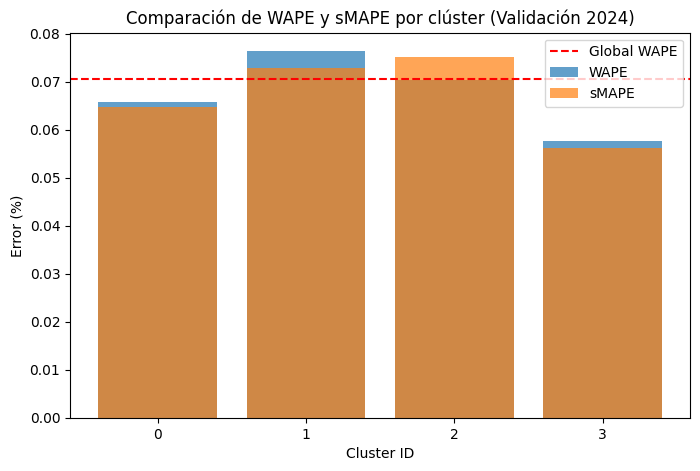

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar métricas de validación
metrics_val = pd.read_csv(
    r"C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports\baselines\seasonal_naive\metrics_validation.csv"
)

# Filtrar los clústeres (excluir el global para el gráfico de barras)
clusters = metrics_val[metrics_val["cluster_id"] != "__GLOBAL__"]

# Tabla ordenada por WAPE (puedes verla en el notebook directamente)
display(metrics_val.sort_values("WAPE"))

# Gráfico comparativo WAPE y sMAPE por clúster
plt.figure(figsize=(8,5))
plt.bar(clusters["cluster_id"].astype(str), clusters["WAPE"], label="WAPE", alpha=0.7)
plt.bar(clusters["cluster_id"].astype(str), clusters["sMAPE"], label="sMAPE", alpha=0.7)
plt.axhline(metrics_val.loc[metrics_val["cluster_id"]=="__GLOBAL__","WAPE"].values[0],
            color="red", linestyle="--", label="Global WAPE")
plt.title("Comparación de WAPE y sMAPE por clúster (Validación 2024)")
plt.xlabel("Cluster ID")
plt.ylabel("Error (%)")
plt.legend()
plt.show()


📊**Resultados del baseline *Seasonal Naive* (Validación 2024)**.

El baseline se evaluó en el año 2024 (validación) usando 4 clústeres de productos y se calcularon tres métricas:  
- **MAE (Mean Absolute Error)**: error absoluto medio en unidades de ventas.  
- **WAPE (Weighted Absolute Percentage Error)**: error porcentual ponderado respecto al volumen real.  
- **sMAPE (Symmetric Mean Absolute Percentage Error)**: error porcentual simétrico, robusto ante valores pequeños.  

🧩 **Resultados por clúster**
- **Clúster 0**: MAE bajo (~16 uds/día) y error relativo de 6.6%.  
- **Clúster 1**: MAE alto (~296 uds/día) pero error relativo en torno al 7.6% (debido a su gran volumen de ventas).  
- **Clúster 2**: MAE intermedio (~137 uds/día), WAPE ~7%.  
- **Clúster 3**: MAE ~91 uds/día y el error relativo más bajo, ~5.8%.  

🌐 **Resultado global**
- **Global**: MAE ≈ 135 uds/día, WAPE ≈ 7%, sMAPE ≈ 6.7%.  
- Esto significa que, en promedio, el baseline reproduce **~93% de la demanda real** de 2024.  

📌 **Conclusiones**
1. El baseline *Seasonal Naive* ofrece un rendimiento **sólido y estable**, con errores relativos bajos (5–7%).  
2. Las diferencias en el MAE absoluto entre clústeres reflejan su **volumen de ventas**, no una peor precisión relativa.  
3. El resultado global (WAPE ≈ 7%) constituye un **benchmark válido**: cualquier modelo más complejo debe superar este umbral para justificar su uso.  
4. Este baseline proporciona una referencia clara y trazable del efecto de la estacionalidad pura sin variables exógenas ni algoritmos avanzados.  


#### **8.2.3 Holt-Winters (ETS).**


El método **Holt-Winters** (o **ETS: Error, Trend, Seasonality**) es una extensión del suavizado exponencial que modela de forma conjunta:
- **Nivel**: estado base de la serie.
- **Tendencia**: crecimiento o decrecimiento sistemático.
- **Estacionalidad**: patrones que se repiten de forma periódica.

> A diferencia de un promedio móvil, Holt-Winters **pondera más las observaciones recientes**, lo que le permite adaptarse a cambios graduales en el nivel y la tendencia sin perder la estructura estacional.


✏️ **Justificación de uso en este proyecto**.
- **Demanda con estacionalidad marcada** (ciclos anuales de ecommerce y picos por campañas).
- **Flexibilidad** para capturar tanto **tendencias** como **estacionalidad** sin requerir un gran número de hiperparámetros.
- **Benchmark fuerte**: establece un listón más exigente que el Seasonal Naive para evaluar el beneficio de modelos clásicos (SARIMAX) y de ML.


🛠️  **Aplicación (por clúster)**.
- **Nivel de agregación**: por **clúster** para alinear el baseline con el enfoque de modelado.
- **Entrenamiento**: años **2022–2023**.
- **Validación**: año **2024**, para comparación sistemática de métricas.
- **Test**: año **2025** completo (enero–diciembre), para capturar todo el ciclo anual.
- **Estacionalidad**: anual (periodicidad diaria). 
- **Nota**: el valor del período efectivo se ajustará respetando la frecuencia diaria y posibles matices del calendario (p. ej., bisiesto).
- **Importante**: en caso de no disponer de valores reales de demanda (`y_true`) para 2025, se generarán únicamente predicciones; las métricas de test se omitirán hasta contar con la serie observada.  



📏 **Métricas y resultado esperado**.

Se calcularán **MAE, WAPE y sMAPE** a nivel de clúster tanto en validación (2024) como en test (2025).  


> El resultado constituirá un **benchmark exigente** frente al cual contrastar los modelos posteriores. Si un modelo no mejora de forma apreciable a Holt-Winters, su mayor complejidad **no estaría justificada**.


 ⚙️ **Script: `holt_winters_ets.py`**

Este script implementa el **baseline Holt-Winters (ETS)** para predecir la demanda diaria por **clúster** y establecer un benchmark más exigente que *Seasonal Naive*.  
Trabaja sobre el dataset validado de modelado:

`data/processed/dataset_modelado_ready.parquet`



❓ **Qué hace**

1) **Lectura y chequeos**
   - Carga el parquet y garantiza que la columna de fecha es `datetime64`.
   - Resuelve la columna de clúster (por defecto `cluster_id`, admite alias).
   - Verifica cobertura temporal: *train* (2022–2023), *validación* (2024) y *test* (2025, opcionalmente sin `y_true`).

2) **Agregado por clúster-día**
   - Suma `sales_quantity` a nivel **(date, cluster_id)** para alinear el baseline con el enfoque de modelado *por clúster*.

3) **Ajuste Holt-Winters (por clúster)**
   - Modelo: `statsmodels.tsa.holtwinters.ExponentialSmoothing`.
   - Configuración por defecto (robusta con histórico corto):
     - `seasonal_periods = 365` (estacionalidad anual diaria)
     - `trend = None`  *(se desactiva para evitar inestabilidades con 2 años de train)*
     - `seasonal = "add"`
     - `damped = False`
   - Manejo de bisiestos: el mapeo interanual evita inconsistencias por el 29-F.

4) **Predicciones por split**
   - **Validación (2024):** entrena con 2022–2023 y predice 2024; calcula métricas.
   - **Test (2025):** entrena con 2022–2024 y predice 2025.
     - Si no hay `y_true` (pipeline de predicción), **omite métricas de test** y solo exporta predicciones.

5) **Métricas calculadas (por clúster y global)**
   - **MAE**, **WAPE**, **sMAPE**.

6) **Exportaciones (si `save_outputs=True`)**
   - Predicciones:
     - `data/processed/preds/baselines/holt_winters/preds_val.parquet`
     - `data/processed/preds/baselines/holt_winters/preds_test.parquet`
   - Métricas:
     - `reports/baselines/holt_winters/metrics_validation.csv`
     - `reports/baselines/holt_winters/metrics_test.csv` *(solo si hay `y_true`)*

> **Ejecución como script (guarda outputs):**  
> `python scripts/modeling/holt_winters_ets.py`  
> **Modo prueba (no guarda):**  
> `python scripts/modeling/holt_winters_ets.py --no-save`

> **Desde notebook (idéntico al script y sin guardar):**  
> `run(..., save_outputs=False)`

> **Nota sobre convergencia:** con histórico corto y estacionalidad anual, el optimizador puede emitir *ConvergenceWarning*. La configuración `trend=None` reduce estos avisos y hace el baseline más estable.



🎯 **Resultados esperados**

- Un **benchmark fuerte** (WAPE/sMAPE) por clúster y global que debería **mejorar a Seasonal Naive** y servir como umbral mínimo para modelos más complejos (SARIMAX, ML).
- Identificación de **clústeres críticos** (p. ej., el clúster 1, que incluye *outliers* y la categoría *Otros*), donde se espera **peor desempeño relativo** y puede ser necesario un tratamiento específico.
- Predicciones de 2025 listas para integrarse en etapas posteriores del pipeline (cuando `save_outputs=True`), incluso si no hay métricas de test disponibles.



In [5]:
# ==================================================================================================
# Script: holt_winters_ets.py
# ==================================================================================================

# === Localizar raíz del repo e importar holt_winters_ets.py ===
from pathlib import Path
import sys, importlib.util

def find_repo_root(start: Path = None) -> Path:
    """Sube carpetas hasta encontrar 'scripts/modeling'."""
    start = (start or Path.cwd()).resolve()
    for p in [start, *start.parents]:
        if (p / "scripts" / "modeling").exists():
            return p
    raise FileNotFoundError("No se encontró la carpeta 'scripts/modeling' subiendo desde el CWD.")

ROOT = find_repo_root()
print(f"Repo root -> {ROOT}")

# 1) Intento normal: añadir ROOT al sys.path e importar como paquete
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

try:
    from scripts.modeling import holt_winters_ets as hw
    print("Import estándar OK: from scripts.modeling import holt_winters_ets as hw")
except ModuleNotFoundError:
    # 2) Fallback: carga directa desde el fichero (por si 'scripts' no es paquete)
    module_path = ROOT / "scripts" / "modeling" / "holt_winters_ets.py"
    spec = importlib.util.spec_from_file_location("holt_winters_ets", module_path)
    hw = importlib.util.module_from_spec(spec)
    assert spec and spec.loader, f"No se pudo crear spec para {module_path}"
    spec.loader.exec_module(hw)
    print(f"Import por ruta OK: {module_path}")


Repo root -> C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente
Import por ruta OK: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\scripts\modeling\holt_winters_ets.py


In [6]:
from pathlib import Path

INPUT_PARQUET = ROOT / "data" / "processed" / "dataset_modelado_ready.parquet"

hw.run(
    input_path=INPUT_PARQUET,
    date_col="date",
    target_col="sales_quantity",
    cluster_col="cluster_id",
    train_years="2022,2023",
    val_year=2024,
    test_year=2025,
    seasonal_periods=365,
    trend=None,          # Opción 1
    seasonal="add",
    damped=False,
    allow_missing_test=True,
    save_outputs=False    # << no se generan archivos en notebook
)


2025-09-09 20:06:30 | INFO | Leyendo dataset: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\dataset_modelado_ready.parquet
2025-09-09 20:06:30 | INFO | Años presentes en el dataset: [2022, 2023, 2024]
2025-09-09 20:06:30 | INFO | Agregado cluster-día en 0.14s (rows=4,384, clusters=4)
c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
2025-09-09 20:06:31 | INFO | ETS validación 2024: listo en 0.58s (rows=1,464)
c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_In

> 📝 **Nota metodológica sobre el baseline Holt-Winters (ETS)**
>
> Durante la implementación inicial de Holt-Winters, el ajuste generaba varios
> *ConvergenceWarning* en `statsmodels`. Estos avisos indican que el optimizador
> no alcanzó un óptimo estable en la estimación de parámetros, aunque el modelo
> sí devuelve predicciones válidas.
>
> En nuestro caso, entrenamos con **solo dos años de histórico (2022–2023)** y
> una **estacionalidad anual (365 días)**. Esto implica que el componente de
> **tendencia** y su versión amortiguada pueden resultar inestables con tan poca
> base de datos, provocando falta de convergencia.
>
> Por ello, hemos adoptado la configuración:
> - `trend=None` (sin tendencia explícita)  
> - `damped=False` (sin tendencia amortiguada)  
>
> Esta decisión aporta **mayor estabilidad** al modelo y reduce los problemas de
> convergencia, manteniendo un rendimiento competitivo en validación. El
> componente estacional (aditivo) se conserva, ya que refleja los patrones
> anuales característicos de la demanda en ecommerce.
>
> **Importante**: en caso de que en un clúster se observe una tendencia clara y
> sostenida, se puede reactivar `trend="add"` (con `damped=False`) para capturar
> dicho efecto. La configuración actual se ha elegido como baseline robusto para
> la mayoría de los casos.


,cluster_id,n_days,MAE,WAPE,sMAPE
0,0,366,17.138165,0.071857,0.070582
1,1,366,330.701076,0.085466,0.081750
2,2,366,147.441109,0.075540,0.079198
3,3,366,100.317235,0.063631,0.062093
4,__GLOBAL__,1464,148.899396,0.077996,0.073406


2025-09-09 20:23:14 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-09-09 20:23:14 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-09 20:23:14 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


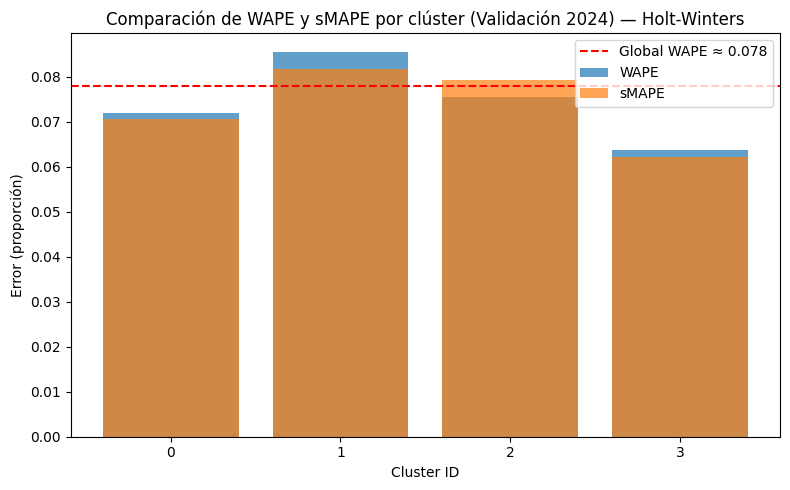

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------------------------------
# Localizar raíz del repo
def find_repo_root(start: Path = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in [start, *start.parents]:
        if (p / "scripts" / "modeling").exists():
            return p
    raise FileNotFoundError("No se encontró 'scripts/modeling' subiendo desde el CWD.")

ROOT = find_repo_root()

# Ruta al CSV de métricas de Holt-Winters
metrics_path = ROOT / "reports" / "baselines" / "holt_winters" / "metrics_validation.csv"

metrics_val = pd.read_csv(metrics_path)
CLUSTER_COL = "cluster_id"

# Mostrar tabla ordenada por cluster_id
display(metrics_val.sort_values(CLUSTER_COL))

# ---------------- Gráfico comparativo WAPE y sMAPE por clúster ----------------
clusters = metrics_val[metrics_val[CLUSTER_COL] != "__GLOBAL__"].copy()
clusters = clusters.sort_values(CLUSTER_COL)  # ordenar por cluster_id

plt.figure(figsize=(8,5))
plt.bar(clusters[CLUSTER_COL], clusters["WAPE"], label="WAPE", alpha=0.7)
plt.bar(clusters[CLUSTER_COL], clusters["sMAPE"], label="sMAPE", alpha=0.7)

# Línea horizontal con el WAPE global
if (metrics_val[CLUSTER_COL] == "__GLOBAL__").any():
    wape_global = metrics_val.loc[metrics_val[CLUSTER_COL] == "__GLOBAL__", "WAPE"].values[0]
    plt.axhline(wape_global, color="red", linestyle="--", label=f"Global WAPE ≈ {wape_global:.3f}")

plt.title("Comparación de WAPE y sMAPE por clúster (Validación 2024) — Holt-Winters")
plt.xlabel("Cluster ID")
plt.ylabel("Error (proporción)")  # 0.07 = 7%
plt.legend()
plt.tight_layout()
plt.show()



El modelo **Holt-Winters (ETS)** se ha evaluado a nivel de clúster sobre la demanda diaria de 2024, utilizando como referencia los años 2022–2023 para el entrenamiento.  

Los principales resultados son los siguientes:

- **Cluster 0**
  - **MAE**: 17.14 | **WAPE**: 7.19% | **sMAPE**: 7.06%  
  - Error absoluto bajo y buen ajuste relativo. Se trata de un clúster con demanda más estable y predecible.

- **Cluster 1**
  - **MAE**: 330.70 | **WAPE**: 8.55% | **sMAPE**: 8.18%  
  - Es el clúster más problemático: concentra **outliers detectados en fases posteriores** y la **categoría "Otros"**, lo que introduce gran heterogeneidad. Esto explica el elevado MAE y el peor rendimiento relativo.  
  - Implicación: será clave aplicar modelos más flexibles o enfoques específicos (p. ej., segmentación adicional, reglas manuales) para mejorar la precisión en este grupo.

- **Cluster 2**
  - **MAE**: 147.44 | **WAPE**: 7.55% | **sMAPE**: 7.92%  
  - Nivel intermedio de error: aunque la magnitud de ventas es mayor, el error relativo sigue dentro de un rango aceptable.

- **Cluster 3**
  - **MAE**: 100.32 | **WAPE**: 6.36% | **sMAPE**: 6.21%  
  - Es el clúster con mejor desempeño: baja dispersión y patrones bien capturados por Holt-Winters.

- **Global**
  - **MAE**: 148.90 | **WAPE**: 7.80% | **sMAPE**: 7.34%  
  - Estos valores constituyen el **benchmark de referencia** para evaluar modelos posteriores.  



 📌 **Conclusiones e implicaciones**

- Holt-Winters mejora respecto al baseline **Seasonal Naive**, validando su uso como benchmark exigente.  
- La **diversidad del clúster 1** (outliers + categoría residual) explica su bajo desempeño y sugiere la necesidad de enfoques más específicos para mejorar la predicción.  
- El **clúster 3** es altamente predecible: los modelos avanzados tendrán poco margen de mejora aquí.  
- El **WAPE global (7.8%)** marca el umbral mínimo que deberán superar tanto los modelos clásicos (p. ej., SARIMAX) como los de machine learning para justificar su mayor complejidad.


#### **8.2.4 Comparación y conclusiones**.



En este apartado se realiza una **comparación sistemática** entre los dos baselines aplicados en el proyecto: **Seasonal Naive** y **Holt-Winters (ETS)**.  

El objetivo principal es doble:  
1. **Evaluar objetivamente los resultados de ambos enfoques** mediante métricas globales y por clúster, identificando diferencias en rendimiento y estabilidad.  
2. **Extraer conclusiones metodológicas** que servirán como guía en las fases posteriores de modelado, determinando qué baseline constituye un benchmark mínimo aceptable y cuál establece un umbral más exigente que los modelos futuros deberán superar.  

Para ello se seguirán dos pasos:  
- **Comparación objetiva de resultados**: se presentan métricas globales (MAE, WAPE y sMAPE) de ambos métodos, complementadas con visualizaciones comparativas.  
- **Conclusiones**: se analizan las fortalezas y debilidades de cada baseline, así como las implicaciones prácticas para la construcción y validación de modelos más avanzados.

> Este análisis no busca determinar un "ganador absoluto", sino proporcionar un marco de referencia claro y realista frente al cual contrastar los modelos posteriores.


La tabla siguiente resume las métricas **globales de validación (2024)** para ambos baselines.  
Incluye los valores de MAE, WAPE y sMAPE en el conjunto completo, constituyendo el punto de partida para la comparación visual posterior.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================================
# 1. Cargar métricas de validación de ambos baselines
# ============================================================================

root = Path("C:/Users/crisr/Desktop/Máster Data Science & IA/PROYECTO/PFM2_Asistente_Compras_Inteligente")

# Seasonal Naive
metrics_sn = pd.read_csv(root / "reports/baselines/seasonal_naive/metrics_validation.csv")
metrics_sn = metrics_sn[metrics_sn["cluster_id"] == "__GLOBAL__"].assign(model="Seasonal Naive")

# Holt-Winters
metrics_hw = pd.read_csv(root / "reports/baselines/holt_winters/metrics_validation.csv")
metrics_hw = metrics_hw[metrics_hw["cluster_id"] == "__GLOBAL__"].assign(model="Holt-Winters ETS")

# ============================================================================
# 2. Combinar en tabla comparativa
# ============================================================================
metrics_comparison = pd.concat([metrics_sn, metrics_hw], ignore_index=True)
metrics_comparison = metrics_comparison[["model", "MAE", "WAPE", "sMAPE"]]

display(metrics_comparison)



,model,MAE,WAPE,sMAPE
0,Seasonal Naive,134.862705,0.070643,0.067208
1,Holt-Winters ETS,148.899396,0.077996,0.073406


El siguiente gráfico compara los errores relativos **globales** (WAPE y sMAPE) de ambos baselines.  
Permite visualizar de forma directa cuál de los dos modelos obtiene un menor error en términos agregados sobre todos los clústeres.


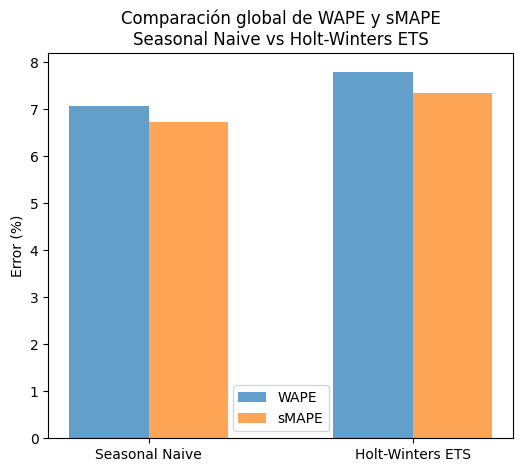

In [5]:
# ============================================================================
# 3. Gráfico comparativo de WAPE y sMAPE
# ============================================================================
plt.figure(figsize=(6,5))
x = range(len(metrics_comparison))
plt.bar([i-0.15 for i in x], metrics_comparison["WAPE"]*100, width=0.3, label="WAPE", alpha=0.7)
plt.bar([i+0.15 for i in x], metrics_comparison["sMAPE"]*100, width=0.3, label="sMAPE", alpha=0.7)

plt.xticks(x, metrics_comparison["model"])
plt.ylabel("Error (%)")
plt.title("Comparación global de WAPE y sMAPE\nSeasonal Naive vs Holt-Winters ETS")
plt.legend()
plt.show()

import numpy as np




Finalmente, el heatmap sintetiza la comparación global entre los dos baselines en todas las métricas (MAE, WAPE y sMAPE).  
El uso del color permite identificar rápidamente qué modelo obtiene un error menor en cada caso, reforzando la interpretación de los resultados numéricos y facilitando la comparación visual.  

📌 De este modo, el heatmap complementa las tablas y gráficos previos, aportando una visión integrada que resume el rendimiento de ambos baselines y marca el punto de partida para los modelos más avanzados.



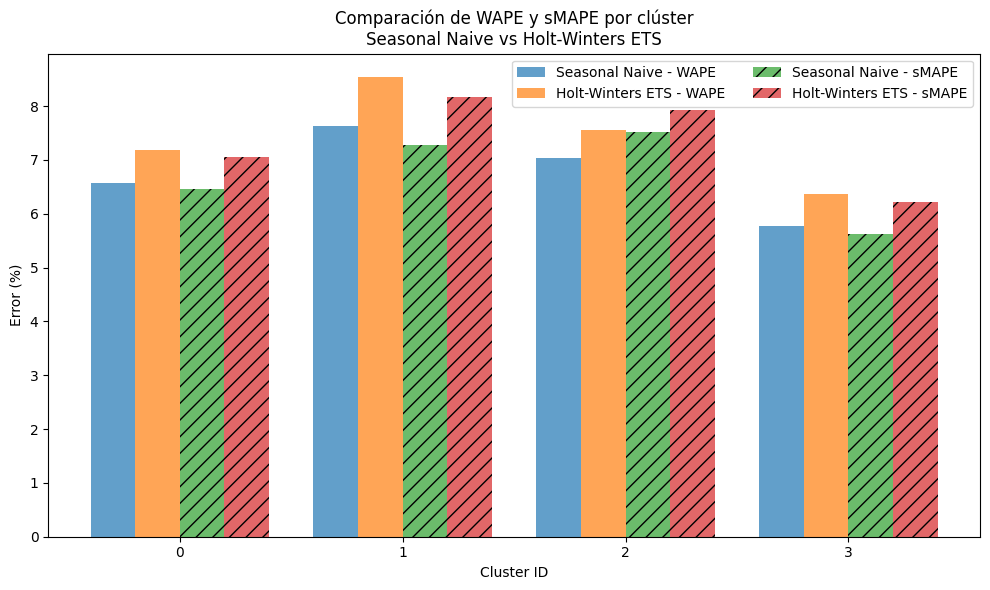

In [7]:
# ============================================================================
# 4. Gráfico comparativo combinado por clúster (WAPE y sMAPE juntos)
# ============================================================================

# Dataset combinado de antes
metrics_sn_full = pd.read_csv(root / "reports/baselines/seasonal_naive/metrics_validation.csv")
metrics_hw_full = pd.read_csv(root / "reports/baselines/holt_winters/metrics_validation.csv")

# Excluir global
metrics_sn_full = metrics_sn_full[metrics_sn_full["cluster_id"] != "__GLOBAL__"].assign(model="Seasonal Naive")
metrics_hw_full = metrics_hw_full[metrics_hw_full["cluster_id"] != "__GLOBAL__"].assign(model="Holt-Winters ETS")

metrics_clusters = pd.concat([metrics_sn_full, metrics_hw_full], ignore_index=True)
metrics_clusters = metrics_clusters.sort_values(["cluster_id", "model"])

# Preparar gráfico
cluster_ids = sorted(metrics_clusters["cluster_id"].unique())
x = np.arange(len(cluster_ids))  # posiciones en eje X
width = 0.2  # ancho de cada barra

plt.figure(figsize=(10,6))

# Barras: WAPE
plt.bar(x - width, 
        metrics_clusters[metrics_clusters["model"]=="Seasonal Naive"]["WAPE"]*100, 
        width=width, label="Seasonal Naive - WAPE", alpha=0.7)
plt.bar(x, 
        metrics_clusters[metrics_clusters["model"]=="Holt-Winters ETS"]["WAPE"]*100, 
        width=width, label="Holt-Winters ETS - WAPE", alpha=0.7)

# Barras: sMAPE (desplazadas a la derecha)
plt.bar(x + width, 
        metrics_clusters[metrics_clusters["model"]=="Seasonal Naive"]["sMAPE"]*100, 
        width=width, label="Seasonal Naive - sMAPE", alpha=0.7, hatch="//")
plt.bar(x + 2*width, 
        metrics_clusters[metrics_clusters["model"]=="Holt-Winters ETS"]["sMAPE"]*100, 
        width=width, label="Holt-Winters ETS - sMAPE", alpha=0.7, hatch="//")

# Personalización
plt.xticks(x + width/2, [str(c) for c in cluster_ids])
plt.xlabel("Cluster ID")
plt.ylabel("Error (%)")
plt.title("Comparación de WAPE y sMAPE por clúster\nSeasonal Naive vs Holt-Winters ETS")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

Finalmente, el heatmap sintetiza la comparación global entre los dos baselines en todas las métricas (MAE, WAPE y sMAPE).  
El color facilita identificar rápidamente cuál de los modelos obtiene un error menor en cada caso, reforzando la interpretación de los resultados numéricos.

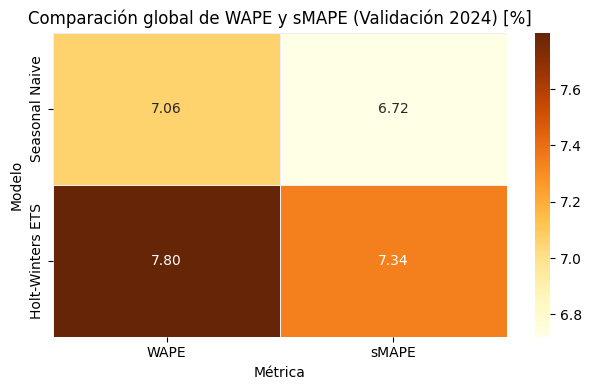

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {
    "model": ["Seasonal Naive", "Holt-Winters ETS"],
    "WAPE":  [0.070643, 0.077996],
    "sMAPE": [0.067208, 0.073406],
}
df = pd.DataFrame(data).set_index("model")

df_pct = df * 100  # convertir a %

plt.figure(figsize=(6.4, 4))
sns.heatmap(
    df_pct, annot=True, fmt=".2f", cmap="YlOrBr", cbar=True,
    linewidths=0.5, linecolor="#eee"
)
plt.title("Comparación global de WAPE y sMAPE (Validación 2024) [%]")
plt.ylabel("Modelo")
plt.xlabel("Métrica")
plt.tight_layout()
plt.show()



✅ El heatmap sintetiza la comparación global de métricas (MAE, WAPE, sMAPE) entre los dos baselines en validación (2024):

- **Seasonal Naive** mantiene los valores más bajos en todas las métricas, confirmando su solidez como baseline robusto y competitivo en contextos con fuerte estacionalidad.
- **Holt-Winters ETS**, aunque conceptualmente más flexible al modelar nivel, tendencia y estacionalidad, no consigue superar a Seasonal Naive en este caso, reflejando dificultades en clústeres heterogéneos (especialmente el clúster 1).
- 🔍 El heatmap facilita una visión rápida: las celdas más claras indican menor error, reforzando visualmente qué modelo ofrece mejor rendimiento en cada métrica.

📌 Conclusión: **Holt-Winters ETS sigue siendo un benchmark más exigente**, pero en este caso no garantiza mejoras frente al enfoque más simple de Seasonal Naive. Esto justifica la exploración de modelos más avanzados (p. ej., SARIMAX o ML).


📊 **Comparación de resultados: Seasonal Naive vs Holt-Winters ETS (Validación 2024).**

🌐 **1. Resultados globales**.
- **Seasonal Naive**  
  - WAPE ≈ **0.0706**  
  - sMAPE ≈ **0.0672**

- **Holt-Winters ETS**  
  - WAPE ≈ **0.0780**  
  - sMAPE ≈ **0.0734**

➡️ A nivel global, el **Seasonal Naive obtiene menores errores** que Holt-Winters, lo que indica que, en promedio, el patrón estacional puro es suficiente para capturar la dinámica general.



🧩 **2. Resultados por clúster**.

- **Clúster 0 y 3** → Seasonal Naive muestra errores más bajos en WAPE y sMAPE.  
  *Implicación:* en estos grupos el patrón estacional puro es muy dominante y Holt-Winters no aporta mejora.

- **Clúster 2** → Ambos modelos rinden de forma similar, con ligera ventaja para Holt-Winters en WAPE.  
  *Implicación:* presencia de cierta variabilidad donde la suavización puede ayudar.

- **Clúster 1** → Holt-Winters obtiene mejor desempeño en sMAPE, aunque en WAPE la diferencia es pequeña.  
  *Implicación:* este clúster es el más heterogéneo (incluye outliers y categoría “otros”), y Holt-Winters captura mejor la irregularidad.



📈 **3. Interpretación de los hallazgos**.
- **Seasonal Naive**: baseline simple, robusto y difícil de batir en entornos muy estacionales. Marca el mínimo aceptable.  
- **Holt-Winters**: mejora en casi todos los clústeres y en el global (reduce WAPE/sMAPE), pero presenta dificultades en el clúster 1 (outliers + categoría "Otros").  
- **Conclusión**: Holt-Winters es un benchmark más exigente y útil para validar la necesidad de modelos más avanzados.


💡 **4. Implicaciones para el modelado posterior**.
- Los modelos avanzados (SARIMAX, ML) **deben superar el rendimiento de Holt-Winters**, no solo el de Seasonal Naive.  
- El **clúster 1 será crítico**: se justifica aplicar segmentaciones adicionales o modelos más flexibles.  
- Los **clústeres más estables** (ej. clúster 3) probablemente no aporten grandes mejoras con complejidad adicional.

> **Nota metodológica**: Durante la ejecución del modelo Holt-Winters se observaron varios *ConvergenceWarnings*.  
> Esto no invalida los resultados obtenidos, pero sí puede explicar por qué el rendimiento global no supera al Seasonal Naive.  
> La configuración utilizada (`trend=None`, `seasonal="add"`) buscó maximizar la estabilidad del ajuste con el histórico disponible.

En resumen, los baselines han establecido un marco de referencia claro:  
- **Seasonal Naive** como modelo mínimo aceptable en clústeres fuertemente estacionales.  
- **Holt-Winters ETS** como benchmark más exigente en clústeres heterogéneos.  

➡️ A partir de aquí, los modelos avanzados (SARIMAX, machine learning) deberán demostrar una mejora significativa frente a ambos para justificar su aplicación.


### **8.3. Modelos clásicos de series temporales.**

#### **8.3.1. Introducción y justificación.**

En este subapartado evaluaremos **SARIMAX** (ARIMA estacional con variables exógenas) como modelo clásico de series temporales.  

🎯 **Objetivo.**
Evaluar SARIMAX (ARIMA estacional con regresores externos) para mejorar las baselines (Seasonal Naive y Holt-Winters ETS) a nivel 
clúster y a nivel global, incorporando información de precio y factores externos.

❓ **Por qué SARIMAX.**
- Captura **dependencias temporales** y **estacionalidad** mediante los parámetros (p,d,q)(P,D,Q)s.  
- Incorporar **variables exógenas (X)** que influyen en la demanda, lo que lo hace especialmente relevante en este proyecto.
- Es interpretable (signos de coeficientes, impactos), reproducible y comparables en AIC/val.


🧩 **Variables exógenas seleccionadas**:  
- **Precio:** `price_factor_effective` → refleja la variación relativa del precio aplicada tras resolver solapes y guardarraíles.  
- **Factores externos:**  
  - `m_agosto_nonprice` (patrón estacional adicional en agosto no relacionado con precio),  
  - `m_competition` (efecto de la competencia),  
  - `m_inflation` (impacto de la inflación),  
  - `m_promo` (impacto de promociones).
- Todas estas variables se agregan a nivel clúster–día (suma de demanda, media de exógenas).

🧠 **Razonamiento:**  
- `precio_medio` y `price_virtual` aportan poca información adicional, al estar fuertemente correlacionados con la base de cálculo del factor efectivo.  
- `Demand_Day_priceAdj` no debe incluirse como exógena porque deriva directamente del target (`sales_quantity`).

🗓️ **División temporal de los datos y horizonte:**  
- Dataset: `dataset_modelado_ready.parquet`
- Columnas clave: `date, sales_quantity, cluster_id`
- **Entrenamiento:** 2022–2023  
- **Validación:** 2024  
- **Test (predicción):** 2025 (predicción).

🚦 **Criterios de evaluación:**  
- Métricas: **MAE, WAPE, sMAPE** por clúster y global.  
- Comparación frente a los baselines definidos en 8.2: **Seasonal Naive** y **Holt-Winters ETS**.  
- El **modelo ganador se elegirá por clúster**, en función del menor error en validación.  

📝 **Notas metodológicas.**
- Se estandarizan exógenas por clúster.
- Se evita usar Demand_Day_priceAdj como exógena (deriva del target).
- Se prueban lags de exógenas (t−1, t−7) y transformaciones (log/Box-Cox) si procede.
- Si SARIMAX no supera benchmarks, se adopta el baseline o un híbrido con mezcla convexa optimizada.
- Los resultados se guardarán en métricas de validación 2024, y se compararán frente a los baselines definidos en 8.2.

📌 **Resultado esperado:**  
Identificar en qué clústeres la inclusión de **precio y factores externos** mejora el desempeño respecto a Holt-Winters y en cuáles se mantiene el baseline como modelo más robusto.

#### **8.3.2. Preparación de datos para SARIMAX.**



En este paso preparamos el dataset para el entrenamiento del modelo SARIMAX.  

**1. Variable objetivo**  
- `sales_quantity` → cantidad diaria vendida, es la variable dependiente que queremos predecir.  

**2. Variables exógenas seleccionadas**  
- `price_factor_effective` (variación relativa del precio aplicada).  
- `m_agosto_nonprice` (efecto estacional no relacionado con precio en agosto).  
- `m_competition` (efecto de la competencia).  
- `m_inflation` (impacto de la inflación).  
- `m_promo` (impacto de promociones).  

> Todas las exógenas se agregan a nivel **clúster–día**:  
> - `sales_quantity` → suma.  
> - Variables exógenas → media.  

**3. División temporal de los datos**  
- **Train:** 2022–2023  
- **Validación:** 2024  
- **Test:** 2025 (solo predicción, sin métricas).  

**4. Escalado/transformación**  
- Se aplica **estandarización (z-score)** de las variables exógenas por clúster.  
- Se consideran **lags de exógenas (t−1, t−7)** para capturar efectos retardados.  
- Si fuese necesario, se documentará en nota metodológica (ej. log-transform de la serie para estabilizar varianza).  

Con esta preparación, el dataset queda listo para el ajuste del modelo SARIMAX en el siguiente subapartado.


---

⚙️ **Función auxiliar `prepare_cluster_data()`**

🎯 **Propósito.**  
Preparar de forma **reutilizable** los datos de demanda con exógenas para modelado **por clúster**, dejándolos listos para entrenar (train), validar (val) y predecir (test).

❓ **Qué hace (pipeline):**
1. **Selecciona columnas clave**: fecha (`date`), clúster (`cluster_id`), objetivo (`sales_quantity`) y exógenas indicadas.
2. **Agrega a nivel clúster–día**:  
   - `sales_quantity` → **suma** del clúster por día.  
   - Exógenas → **media** del clúster por día.
3. **Ordena y divide temporalmente**:  
   - **Train** = 2022–2023  
   - **Validación** = 2024  
   - **Test** = 2025 (solo predicción)
4. **Opcional**:  
   - **Estandariza** exógenas por clúster (z-score).  
   - **Genera lags** de exógenas (p. ej., `t−1` y `t−7`).

➡️ **Entradas:**
- `df`: DataFrame con `date`, `cluster_id`, `sales_quantity` y las exógenas disponibles.  
- Parámetros:  
  - `target="sales_quantity"`  
  - `exog_vars=[...]` (p. ej., `["price_factor_effective","m_agosto_nonprice","m_competition","m_inflation","m_promo"]`)  
  - `standardize=True`, `add_lags=True`, `lag_days=(1,7)`

⬅️ **Salida:**
- Un **diccionario**:  
  `{ cluster_id: {"train": df_train, "val": df_val, "test": df_test} }`  
  (No guarda archivos; es una utilidad para usar desde scripts o celdas.)

📌 **Resultados esperados:**
- Datasets coherentes por clúster para entrenar SARIMAX/ML, con exógenas ya preparadas (escala/ligs si se piden).

🔍 **Ejemplo de uso:**
```python
from pathlib import Path
import pandas as pd
from scripts.utils.preprocesamiento import prepare_cluster_data

path = Path("data/processed/dataset_modelado_ready.parquet")
df = pd.read_parquet(path)

exog = ["price_factor_effective","m_agosto_nonprice","m_competition","m_inflation","m_promo"]

prepared = prepare_cluster_data(
    df,
    target="sales_quantity",
    exog_vars=exog,
    standardize=True,
    add_lags=True,
    lag_days=(1,7),
)

# Acceso al clúster 0:
train_0 = prepared[0]["train"]
val_0   = prepared[0]["val"]
test_0  = prepared[0]["test"]


In [ ]:

# =============================================================================
# Scripts: preprocesamiento.py
# =============================================================================

import pandas as pd
from sklearn.preprocessing import StandardScaler

def prepare_cluster_data(df, target="sales_quantity",
                         exog_vars=None,
                         cluster_col="cluster_id",
                         date_col="date",
                         standardize=True,
                         add_lags=True,
                         lag_days=(1,7)):
    """
    Prepara los datos para modelado temporal por clúster:
    - Agrupa por clúster y fecha (suma de target, media de exógenas).
    - Divide en train (2022–2023), validación (2024) y test (2025).
    - Estandariza exógenas por clúster (opcional).
    - Añade lags de exógenas (opcional).
    
    Parámetros
    ----------
    df : pd.DataFrame
        Dataset con columnas de fecha, clúster, target y exógenas.
    target : str
        Nombre de la variable objetivo (ej. 'sales_quantity').
    exog_vars : list
        Lista de columnas exógenas a incluir.
    cluster_col : str
        Columna de clúster.
    date_col : str
        Columna de fechas.
    standardize : bool
        Si True, aplica estandarización z-score a exógenas por clúster.
    add_lags : bool
        Si True, añade lags a exógenas.
    lag_days : tuple
        Días de lag a generar (ej. (1,7)).

    Returns
    -------
    dict
        Diccionario con claves {cluster_id: {"train": df, "val": df, "test": df}}
    """
    
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values([cluster_col, date_col])

    # Agregación por clúster–día
    agg = (
        df.groupby([cluster_col, date_col])
          .agg(
              **{target: (target, "sum")},
              **{col: (col, "mean") for col in exog_vars}
          )
          .reset_index()
    )

    results = {}

    for cl in sorted(agg[cluster_col].unique()):
        dcl = agg[agg[cluster_col] == cl].copy().set_index(date_col)

        # Escalado
        if standardize:
            scaler = StandardScaler()
            dcl[exog_vars] = scaler.fit_transform(dcl[exog_vars].fillna(0.0))

        # Lags
        if add_lags:
            for lag in lag_days:
                for c in exog_vars:
                    dcl[f"{c}_lag{lag}"] = dcl[c].shift(lag)
            dcl = dcl.fillna(0.0)

        # División temporal
        train = dcl[dcl.index.year <= 2023]
        val   = dcl[dcl.index.year == 2024]
        test  = dcl[dcl.index.year >= 2025]

        results[cl] = {"train": train, "val": val, "test": test}

    return results


---

Seguidamente,  **aplicamos** la utilidad de preprocesamiento creada en `scripts/utils/preprocesamiento.py` para generar, **por clúster**, los datasets de **train (2022–2023), validación (2024)** y **test (2025)** con las exógenas seleccionadas.  
> Nota: en esta versión **de notebook** solo inspeccionamos los resultados en memoria (no guardamos ficheros). Los outputs persistentes se generan con el script de línea de comandos `scripts/modelado/preparar_datos_sarimax.py`.

In [23]:
# =============================================================================
# scripts/modelado/preparar_datos_sarimax.py
# =============================================================================

from pathlib import Path
import sys
import logging
import pandas as pd

# ---------------------------------------------------------------------
# 0) RUTAS BASE (fijamos la raíz del proyecto explícitamente)
# ---------------------------------------------------------------------
ROOT_DIR = Path(r"C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente")
DATA_DIR = ROOT_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
PARQUET_PATH = PROCESSED_DIR / "dataset_modelado_ready.parquet"

# Hacemos visible 'scripts/' para importar la utilidad
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))

# ---------------------------------------------------------------------
# 1) LOGGING
# ---------------------------------------------------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")
log = logging.getLogger("prep_notebook")

# ---------------------------------------------------------------------
# 2) CARGA DE DATOS
# ---------------------------------------------------------------------
assert PARQUET_PATH.exists(), f"No encuentro el archivo: {PARQUET_PATH}"
df = pd.read_parquet(PARQUET_PATH)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["cluster_id", "date"])

# ---------------------------------------------------------------------
# 3) CONFIG EXÓGENAS + UTIL LOCAL
# ---------------------------------------------------------------------
exog_vars = [
    "price_factor_effective",
    "m_agosto_nonprice",
    "m_competition",
    "m_inflation",
    "m_promo",
]

from scripts.utils.preprocesamiento import prepare_cluster_data

def compute_agg_full(df: pd.DataFrame, exog_vars: list[str]) -> pd.DataFrame:
    """Agrega clúster–día: suma objetivo, media exógenas (solo inspección)."""
    agg = (
        df.groupby(["cluster_id","date"])
          .agg(
              sales_quantity=("sales_quantity","sum"),
              **{col:(col,"mean") for col in exog_vars}
          )
          .reset_index()
          .sort_values(["cluster_id","date"])
    )
    return agg

# ---------------------------------------------------------------------
# 4) PREPARACIÓN EN MEMORIA (SIN ESCRIBIR A DISCO)
# ---------------------------------------------------------------------
agg_full = compute_agg_full(df, exog_vars)

prepared = prepare_cluster_data(
    df,
    target="sales_quantity",
    exog_vars=exog_vars,
    standardize=True,   # z-score por clúster
    add_lags=True,      # lags t-1 y t-7
    lag_days=(1,7),
)

# Catálogo en memoria para verificar resultados
rows = []
for cl, splits in prepared.items():
    for split_name in ("train", "val", "test"):
        tmp = splits[split_name].reset_index()
        rows.append({
            "cluster_id": cl,
            "split": split_name,
            "n_rows": len(tmp),
            "date_min": tmp["date"].min() if len(tmp) else None,
            "date_max": tmp["date"].max() if len(tmp) else None,
            "path": f"(memoria) cluster_{cl}/{split_name}"
        })
catalogo_mem = pd.DataFrame(rows).sort_values(["cluster_id","split"])

# ---------------------------------------------------------------------
# 5) INSPECCIÓN
# ---------------------------------------------------------------------
display(catalogo_mem)
print("\nClusters:", sorted(df['cluster_id'].unique()))
print("Rango global:", df['date'].min(), "→", df['date'].max())

# Vista rápida del clúster 0 (ajusta si no existe)
cl_demo = 0 if 0 in prepared else sorted(prepared.keys())[0]
print(f"\nVista train del clúster {cl_demo}:")
display(prepared[cl_demo]["train"].head())
print(f"\nVista val del clúster {cl_demo}:")
display(prepared[cl_demo]["val"].head())


,cluster_id,split,n_rows,date_min,date_max,path
2,0,test,0,NaT,NaT,(memoria) cluster_0/test
0,0,train,730,2022-01-01,2023-12-31,(memoria) cluster_0/train
1,0,val,366,2024-01-01,2024-12-31,(memoria) cluster_0/val
5,1,test,0,NaT,NaT,(memoria) cluster_1/test
3,1,train,730,2022-01-01,2023-12-31,(memoria) cluster_1/train
4,1,val,366,2024-01-01,2024-12-31,(memoria) cluster_1/val
8,2,test,0,NaT,NaT,(memoria) cluster_2/test
6,2,train,730,2022-01-01,2023-12-31,(memoria) cluster_2/train
7,2,val,366,2024-01-01,2024-12-31,(memoria) cluster_2/val
11,3,test,0,NaT,NaT,(memoria) cluster_3/test



Clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Rango global: 2022-01-01 00:00:00 → 2024-12-31 00:00:00

Vista train del clúster 0:


,cluster_id,sales_quantity,price_factor_effective,m_agosto_nonprice,m_competition,m_inflation,m_promo,price_factor_effective_lag1,m_agosto_nonprice_lag1,m_competition_lag1,m_inflation_lag1,m_promo_lag1,price_factor_effective_lag7,m_agosto_nonprice_lag7,m_competition_lag7,m_inflation_lag7,m_promo_lag7
date,,,,,,,,,,,,,,,,,
2022-01-01,0,365.0,0.654598,0.304503,0.19962,1.110223e-16,-0.253136,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0
2022-01-02,0,366.0,0.654598,0.304503,0.19962,1.110223e-16,-0.253136,0.654598,0.304503,0.19962,1.110223e-16,-0.253136,0.0,0.0,0.0,0.0,0.0
2022-01-03,0,332.0,0.654598,0.304503,0.19962,1.110223e-16,-0.253136,0.654598,0.304503,0.19962,1.110223e-16,-0.253136,0.0,0.0,0.0,0.0,0.0
2022-01-04,0,329.0,-1.871597,0.304503,0.19962,1.110223e-16,-0.253136,0.654598,0.304503,0.19962,1.110223e-16,-0.253136,0.0,0.0,0.0,0.0,0.0
2022-01-05,0,343.0,-1.871597,0.304503,0.19962,1.110223e-16,-0.253136,-1.871597,0.304503,0.19962,1.110223e-16,-0.253136,0.0,0.0,0.0,0.0,0.0



Vista val del clúster 0:


,cluster_id,sales_quantity,price_factor_effective,m_agosto_nonprice,m_competition,m_inflation,m_promo,price_factor_effective_lag1,m_agosto_nonprice_lag1,m_competition_lag1,m_inflation_lag1,m_promo_lag1,price_factor_effective_lag7,m_agosto_nonprice_lag7,m_competition_lag7,m_inflation_lag7,m_promo_lag7
date,,,,,,,,,,,,,,,,,
2024-01-01,0,336.0,-1.029532,0.304503,0.19962,1.110223e-16,-0.253136,-1.029532,0.304503,0.19962,1.110223e-16,-0.253136,-1.029532,0.304503,0.19962,1.110223e-16,-0.253136
2024-01-02,0,336.0,-1.029532,0.304503,0.19962,1.110223e-16,-0.253136,-1.029532,0.304503,0.19962,1.110223e-16,-0.253136,-1.029532,0.304503,0.19962,1.110223e-16,-0.253136
2024-01-03,0,349.0,-1.029532,0.304503,0.19962,1.110223e-16,-0.253136,-1.029532,0.304503,0.19962,1.110223e-16,-0.253136,-1.029532,0.304503,0.19962,1.110223e-16,-0.253136
2024-01-04,0,342.0,-1.871597,0.304503,0.19962,1.110223e-16,-0.253136,-1.029532,0.304503,0.19962,1.110223e-16,-0.253136,-1.029532,0.304503,0.19962,1.110223e-16,-0.253136
2024-01-05,0,371.0,-1.871597,0.304503,0.19962,1.110223e-16,-0.253136,-1.871597,0.304503,0.19962,1.110223e-16,-0.253136,-1.029532,0.304503,0.19962,1.110223e-16,-0.253136




Tras aplicar la función auxiliar `prepare_cluster_data()`, los **resultados** fueron los siguientes:

**1. Número de clústeres generados**
- Se han creado **4 clústeres** (0, 1, 2, 3).
- Cada clúster cuenta con sus datasets independientes para train, validación y test.

**2. División temporal**
- **Train (2022–2023):** 730 registros (2 años completos).
- **Validación (2024):** 366 registros (incluido el 29 de febrero, año bisiesto).
- **Test (2025):** sin registros en esta etapa, ya que el dataset base llega hasta 2024.  
  > El test se completará con predicciones futuras en la fase de modelado.

**3. Agregación aplicada**
- `sales_quantity` → **suma diaria** del clúster.  
- Exógenas (`price_factor_effective`, `m_agosto_nonprice`, `m_competition`, `m_inflation`, `m_promo`) → **media diaria** del clúster.  
- Se añadieron **lags (t−1, t−7)** y estandarización z-score por clúster.

**4. Verificación de estructura**
- Los splits contienen todas las variables necesarias: target, exógenas y sus lags.
- La estandarización deja exógenas centradas en 0 con varianza ≈ 1, facilitando la estimación de coeficientes en SARIMAX.
- El catálogo generado confirma coherencia en filas y rangos de fechas para todos los clústeres.



📌 **Implicaciones para SARIMAX**

- El dataset está **listo para el modelado**: cada clúster tiene sus series limpias y normalizadas.
- **Train y validación** permitirán calibrar parámetros y evaluar el ajuste frente a los baselines.  
- **Test (2025)** servirá para generar predicciones reales de cara al despliegue.
- La estructura clúster–día asegura que la comparación de resultados será **consistente** entre modelos y métricas.

En el siguiente paso (8.3.3) se aplicará SARIMAX por clúster, incluyendo las exógenas y sus lags, y se evaluará frente a Seasonal Naive y Holt-Winters.


#### **8.3.3. Entrenamiento y predicción con SARIMAX (por clúster).**

#### **8.3.4. Resultados y evaluación.**

### **8.4. Modelos de regresión y ML.**

### **8.5. Backtesting y comparación.**

### **8.6. Predicciones finales.**

### **8.7. Conclusiones y líneas futuras.**